In [1]:
from collections import namedtuple

import matplotlib as mpl
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

%matplotlib inline

sns.set()

In [79]:
# Load helper functions and allow reloading upon new invocation of %run
%run ./src/helper_functions.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [3]:
device = get_default_device()
print(f"device: {device} \ndevice name: {torch.cuda.get_device_name()}")

device: cuda 
device name: Tesla V100-SXM2-16GB


In [4]:
np.random.seed(42)
random_seed = 42
torch.manual_seed(random_seed);

This notebook focuses on inferring a GLM with partially obsereved inputs. Here, the GLM corresponds to a neuron with a single compartment. 

The encoder model represents an arbritrary model, such as a biophysical model, or real data from a neuron. For now, we are using a very similar architecture as the decoder, but in essence it could be arbitrary.

The decoder is the main model architecture which we use to infer the hidden activity. 

For now, we assume that the neuron receives ten inputs and the GLM observes nine of them

# Model definitions

## Encoder

In [5]:
class neuron_unit_encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 1).to(device)
        self.act1 = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        return x

## Decoder

In [6]:
class neuron_unit_decoder_w_hidden(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 1)
        self.act1 = nn.Sigmoid()
        self.h_activity_vec = torch.nn.Parameter(
            torch.zeros(1000, 1)
        )  # Shape will be num of timepoints

    def forward(self, x):
        # Truncate the last column of x, since that's the index
        # Note: only one example of the training data gets passed on during the forward pass
        #       so the number of rows here are 1, not 1000

        input_wo_time = x[:, :-1].to(device)  # Exclude the timepoint column [1,9]
        timepoint = x[:, -1].to(device)  # [1]

        input_to_network = torch.cat(
            (input_wo_time, self.h_activity_vec[timepoint.long() - 1]), dim=1
        )  # [1,10]

        x = input_to_network
        x = self.linear1(x)
        x = self.act1(x)
        return x

# Preliminary data generation and modelling 
Note: Current method uses a fixed dataset size. This has been replaced in the next notebooks from 02_neuron_params.ipynb, following a more functionalized approach for variable dataset sizes

In [7]:
# Total datset size = 1250 samples
# Training set of 1000 samples, test set of 250 samples

x = np.random.normal(0, 1, size=(5, 1)).T
x2 = torch.normal(0, 1, size=(1250, 10)).to(device)  # Mean = 0, std = 1
print(f"x = {x} \n x2 = {x2}")
inputs = x2[:1000]
inputs_val = x2[1000:]

print(
    f"Train input with shape {inputs.shape} = {inputs} \n\n Test input with shape {inputs_val.shape} {inputs_val}"
)

x = [[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337]] 
 x2 = tensor([[ 1.9269,  1.4873,  0.9007,  ..., -1.6047, -0.7521,  1.6487],
        [-0.3925, -1.4036, -0.7279,  ..., -0.1596, -0.4974,  0.4396],
        [-0.7581,  1.0783,  0.8008,  ...,  1.3347, -0.2316,  0.0418],
        ...,
        [ 1.2037, -1.5801, -0.9531,  ...,  0.2152, -1.5102,  0.4840],
        [ 0.1634, -0.1143, -0.3431,  ..., -1.1820, -0.7586,  1.7937],
        [ 0.8525, -0.5456,  0.1591,  ..., -1.2062, -1.1203,  1.2289]],
       device='cuda:0')
Train input with shape torch.Size([1000, 10]) = tensor([[ 1.9269,  1.4873,  0.9007,  ..., -1.6047, -0.7521,  1.6487],
        [-0.3925, -1.4036, -0.7279,  ..., -0.1596, -0.4974,  0.4396],
        [-0.7581,  1.0783,  0.8008,  ...,  1.3347, -0.2316,  0.0418],
        ...,
        [ 0.6371,  0.9739, -0.2807,  ...,  1.2586,  0.2300,  0.1298],
        [-0.9673,  0.4277, -1.2849,  ..., -0.1432,  0.5898,  0.1672],
        [ 1.3842, -1.2705, -0.4187,  ...,  0.8227, -0.85

In [8]:
model_e = neuron_unit_encoder()
with torch.no_grad():
    output = model_e(inputs)
    output_val = model_e(inputs_val)

print(output[:5], output.shape)
print(output_val[:5], output_val.shape)

tensor([[0.8228],
        [0.6776],
        [0.3580],
        [0.5595],
        [0.4823]], device='cuda:0') torch.Size([1000, 1])
tensor([[0.6833],
        [0.5840],
        [0.6280],
        [0.2431],
        [0.5970]], device='cuda:0') torch.Size([250, 1])


In [9]:
timepoints = torch.arange(start=1, end=inputs.shape[0] + 1).to(device)  # shape is 1000
timepoints = torch.reshape(timepoints, (1000, 1))
print(timepoints.shape)

# Do the same operations for the validation set
timepoints_val = torch.arange(start=1, end=inputs_val.shape[0] + 1).to(device)
timepoints_val = torch.reshape(timepoints_val, (250, 1))
print(timepoints_val.shape)


input_w_time = torch.cat((inputs, timepoints), dim=1)
print(input_w_time[0])

input_w_time_val = torch.cat((inputs_val, timepoints_val), dim=1)
print(input_w_time_val[0])

torch.Size([1000, 1])
torch.Size([250, 1])
tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
        -0.7521,  1.6487,  1.0000], device='cuda:0')
tensor([-1.1723,  0.4068, -0.6165, -0.6137,  1.0867,  0.6168,  0.2854,  1.3248,
        -1.2534, -0.1048,  1.0000], device='cuda:0')


In [10]:
# Create the input with missing 10th neuron values
inputs = inputs.to(device)
inputs_val = inputs_val.to(device)

input_w_hidden = inputs[:, :9].clone()  # [1000,9]
input_w_hidden_val = inputs_val[:, :9].clone()

# print(input_w_hidden)
input_w_time_hidden = torch.cat((input_w_hidden, timepoints), dim=1).to(
    device
)  # [1000,10]
# print(input_w_time_hidden)
input_w_time_hidden_val = torch.cat((input_w_hidden_val, timepoints_val), dim=1).to(
    device
)
# This gets passed on to the decoder network as the input (x)

# Creating the dataloader
train_ds_hidden_params = TensorDataset(input_w_time_hidden, output)
test_ds_hidden_params = TensorDataset(input_w_time_hidden_val, output_val)


batch_size = 256
train_dl_hidden = DataLoader(train_ds_hidden_params, batch_size, shuffle=True)
train_dl_hidden.device = device

test_dl_hidden = DataLoader(test_ds_hidden_params, 250, shuffle=True)
test_dl_hidden.device = device

In [11]:
datagen = namedtuple("datagen", ["inputs", "output", "input_w_time_hidden"])

datagen.inputs = inputs
datagen.output = output
datagen.input_w_time_hidden = input_w_time_hidden
datagen.original = inputs[:, -1].reshape(1000, 1)

# Training loop


In [12]:
def train_decoder_w_hidden(model, loss_fn, l2_lambda, n_epochs=50, learning_rate=1e-4):

    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    model_training_params = dict()
    model_training_params["loss_vals"] = []
    model_training_params["l2_loss_vals"] = []
    model_training_params["validation_loss"] = []
    model_training_params["n_epochs"] = n_epochs

    for i in tqdm(range(n_epochs)):
        epoch_loss = []
        epoch_l2_loss = []
        epoch_val_loss = []

        for xb, yb in train_dl_hidden:
            out = model(xb).to(device)
            yb = yb.to(device)
            loss = loss_fn(out, yb)

            l2_norm = sum(p.pow(2.0).sum() for p in model.h_activity_vec)

            l2_loss = l2_lambda * l2_norm
            loss = loss + l2_loss  # Regularization of hidden param vec

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            epoch_l2_loss.append(l2_loss.item())

        with torch.no_grad():
            model.eval()
            for xb, yb in test_dl_hidden:
                pred = model(xb).to(device)
                yb = yb.to(device)
                val_loss = loss_fn(pred, yb)
                epoch_val_loss.append(val_loss.item())

        model_training_params["loss_vals"].append(sum(epoch_loss) / len(epoch_loss))
        model_training_params["l2_loss_vals"].append(
            sum(epoch_l2_loss) / len(epoch_l2_loss)
        )
        model_training_params["validation_loss"].append(
            sum(epoch_val_loss) / len(epoch_val_loss)
        )

        if (i + 1) % (n_epochs // 5) == 0:
            print(f"iteration {i + 1}/{n_epochs} | train loss: {loss.item():.3f}")

    return model_training_params

In [13]:
# Sanity check for attached parameters to AutoGrad
model_decoder_w_hidden = neuron_unit_decoder_w_hidden().to(device)  # default init
model_decoder_w_hidden.state_dict().keys()

odict_keys(['h_activity_vec', 'linear1.weight', 'linear1.bias'])

# Model training 

In [14]:
# Instantiate different models
model_decoder_w_hidden_no_reg = neuron_unit_decoder_w_hidden().to(
    device
)  # No regularization
model_decoder_w_hidden_01 = neuron_unit_decoder_w_hidden().to(device)  # Lambda = 0.1
model_decoder_w_hidden_001 = neuron_unit_decoder_w_hidden().to(device)  # Lambda = 0.01

In [15]:
loss_fn = nn.MSELoss()
num_epochs = 2000

In [16]:
model_training_params = train_decoder_w_hidden(
    model_decoder_w_hidden_no_reg, loss_fn, n_epochs=num_epochs, l2_lambda=0
)

 20%|██        | 400/2000 [01:50<07:15,  3.68it/s]

iteration 400/2000 | train loss: 0.017


 40%|████      | 800/2000 [03:40<05:26,  3.68it/s]

iteration 800/2000 | train loss: 0.005


 60%|██████    | 1200/2000 [05:31<03:37,  3.68it/s]

iteration 1200/2000 | train loss: 0.001


 80%|████████  | 1600/2000 [07:20<01:52,  3.55it/s]

iteration 1600/2000 | train loss: 0.000


100%|██████████| 2000/2000 [09:10<00:00,  3.63it/s]

iteration 2000/2000 | train loss: 0.000


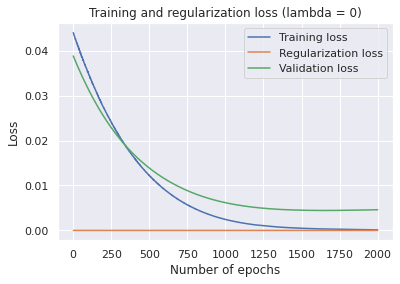

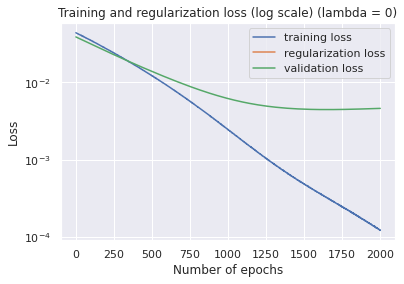

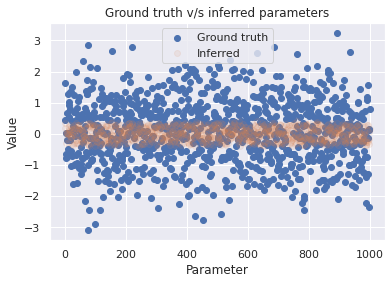

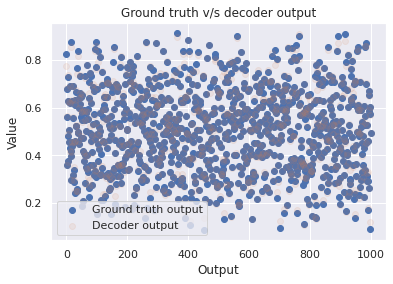

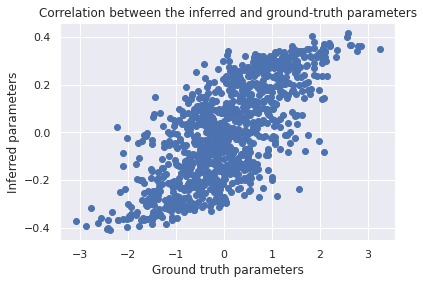

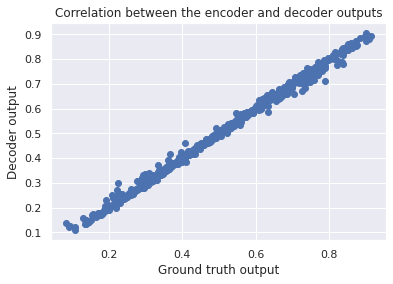

In [18]:
evaluate_model(
    model=model_decoder_w_hidden_no_reg,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=0,
    corr_vals=[],
    corr_flag=False,
)

# Initialize the hidden activity vector with the same variance 
The hidden activity vector is now initialized with the same variance as that of the input 

In [19]:
# Decoder type without 0 initialization of hidden activity vector
class neuron_unit_decoder_w_hidden_same_var(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 1)
        self.act1 = nn.Sigmoid()
        self.h_activity_vec = torch.nn.Parameter(
            torch.normal(0, 1, size=(1000, 1))
        )  # Shape will be num of timepoints

    def forward(self, x):
        input_wo_time = x[:, :-1].to(device)  # Exclude the timepoint column [1,9]
        timepoint = x[:, -1].to(device)

        input_to_network = torch.cat(
            (input_wo_time, self.h_activity_vec[timepoint.long() - 1]), dim=1
        )  # [1,10]

        x = input_to_network
        x = self.linear1(x)
        x = self.act1(x)
        return x

In [20]:
model_decoder_same_var_10e10 = neuron_unit_decoder_w_hidden_same_var().to(
    device
)  # Lambda = 10e-10
model_decoder_same_var_1e5 = neuron_unit_decoder_w_hidden_same_var().to(
    device
)  # Lambda = 1e-5

In [21]:
model_training_params = train_decoder_w_hidden(
    model_decoder_same_var_10e10, loss_fn, n_epochs=num_epochs, l2_lambda=10e-10
)

 20%|██        | 400/2000 [01:49<07:13,  3.69it/s]

iteration 400/2000 | train loss: 0.028


 40%|████      | 800/2000 [03:39<05:34,  3.59it/s]

iteration 800/2000 | train loss: 0.009


 60%|██████    | 1200/2000 [05:30<03:36,  3.69it/s]

iteration 1200/2000 | train loss: 0.004


 80%|████████  | 1600/2000 [07:20<01:47,  3.71it/s]

iteration 1600/2000 | train loss: 0.002


100%|██████████| 2000/2000 [09:10<00:00,  3.64it/s]

iteration 2000/2000 | train loss: 0.002


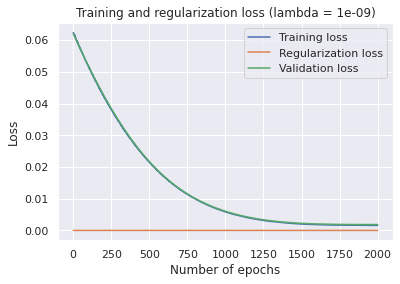

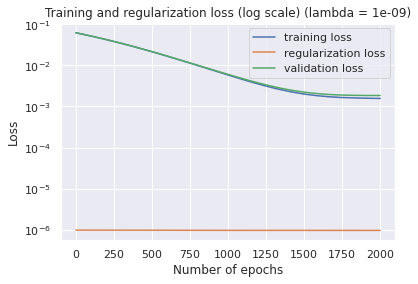

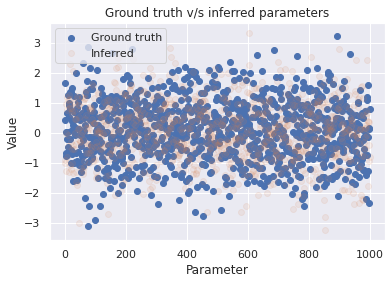

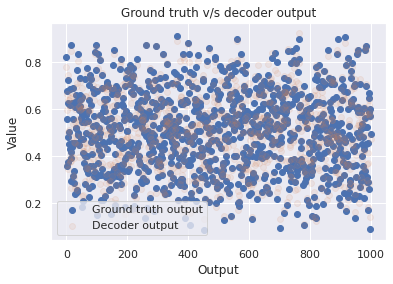

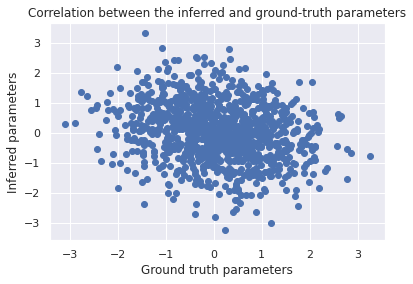

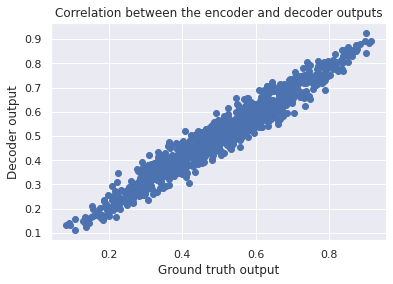

In [22]:
evaluate_model(
    model=model_decoder_same_var_10e10,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=10e-10,
    corr_vals=[],
    corr_flag=False,
)

In [23]:
model_training_params = train_decoder_w_hidden(
    model_decoder_same_var_1e5, loss_fn, n_epochs=num_epochs, l2_lambda=1e-5
)

 20%|██        | 400/2000 [01:49<07:29,  3.56it/s]

iteration 400/2000 | train loss: 0.035


 40%|████      | 800/2000 [03:38<05:21,  3.73it/s]

iteration 800/2000 | train loss: 0.018


 60%|██████    | 1200/2000 [05:27<03:33,  3.74it/s]

iteration 1200/2000 | train loss: 0.010


 80%|████████  | 1600/2000 [07:16<01:47,  3.71it/s]

iteration 1600/2000 | train loss: 0.006


100%|██████████| 2000/2000 [09:05<00:00,  3.67it/s]

iteration 2000/2000 | train loss: 0.005


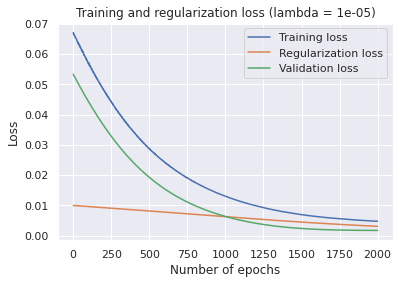

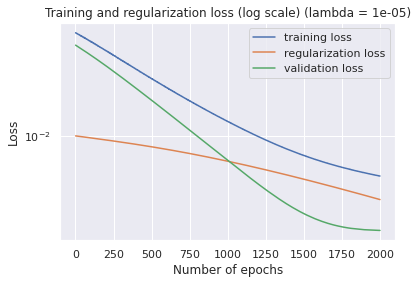

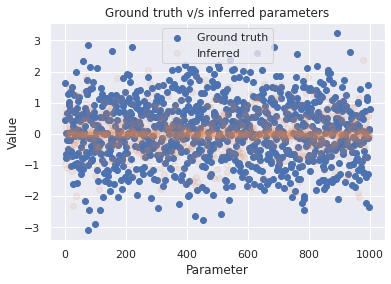

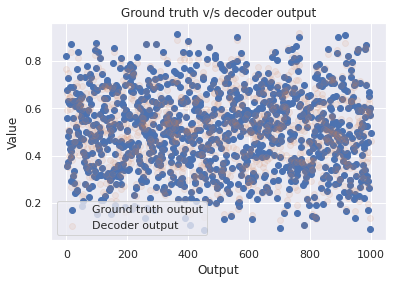

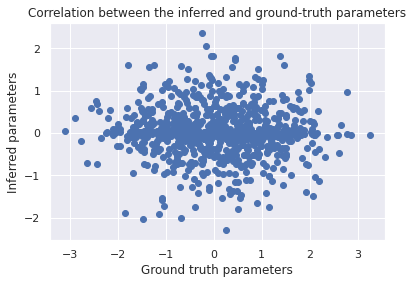

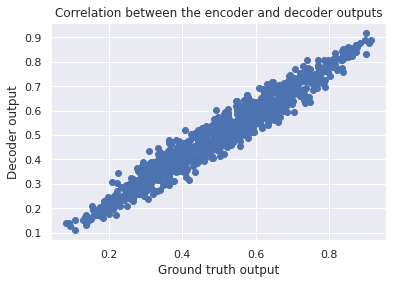

In [24]:
evaluate_model(
    model=model_decoder_same_var_1e5,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-5,
    corr_vals=[],
    corr_flag=False,
)

# Other P - norms 
Using other P-norms apart from the L2 norm. 

The p norms are defined by:

${\lVert x \rVert}_{p} = \left ( \sum_{i=1}^{n} \lvert x_{i} \rvert^{p} \right )^{1/p} $

For example, the L2 norm will be: 
${\lVert x \rVert}_{p} = \sqrt{x^2_1 + x^2_2 + \cdots + x^2_n} $

In [27]:
def train_decoder_w_hidden(
    model, loss_fn, n_lambda, l_norm, n_epochs=50, learning_rate=1e-4
):

    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    model_training_params = dict()
    model_training_params["loss_vals"] = []
    model_training_params["l2_loss_vals"] = []
    model_training_params["validation_loss"] = []
    model_training_params["n_epochs"] = n_epochs

    for i in tqdm(range(n_epochs)):
        epoch_loss = []
        epoch_l2_loss = []
        epoch_val_loss = []

        for xb, yb in train_dl_hidden:
            out = model(xb).to(device)
            yb = yb.to(device)
            loss = loss_fn(out, yb)

            norm = torch.linalg.vector_norm(model.h_activity_vec, ord=l_norm)

            l2_loss = n_lambda * norm
            loss = loss + l2_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            epoch_l2_loss.append(l2_loss.item())

        with torch.no_grad():
            model.eval()
            for xb, yb in test_dl_hidden:
                pred = model(xb).to(device)
                yb = yb.to(device)
                val_loss = loss_fn(pred, yb)
                epoch_val_loss.append(val_loss.item())

        model_training_params["loss_vals"].append(sum(epoch_loss) / len(epoch_loss))
        model_training_params["l2_loss_vals"].append(
            sum(epoch_l2_loss) / len(epoch_l2_loss)
        )
        model_training_params["validation_loss"].append(
            sum(epoch_val_loss) / len(epoch_val_loss)
        )

        if (i + 1) % (n_epochs // 5) == 0:
            print(f"iteration {i + 1}/{n_epochs} | train loss: {loss.item():}")

    return model_training_params

In [26]:
# Instantiate models with various permutations of p-norm and Lambda
# Note: (DEPRECATED) This has been replaced with an automated method
model_decoder_5_norm = neuron_unit_decoder_w_hidden().to(device)
model_decoder_5_norm_1e3 = neuron_unit_decoder_w_hidden().to(device)
model_decoder_5_norm_1e4 = neuron_unit_decoder_w_hidden().to(device)
model_decoder_5_norm_1e5 = neuron_unit_decoder_w_hidden().to(device)
model_decoder_5_norm_1e6 = neuron_unit_decoder_w_hidden().to(device)
model_decoder_5_norm_1e7 = neuron_unit_decoder_w_hidden().to(device)
model_decoder_5_norm_1e8 = neuron_unit_decoder_w_hidden().to(device)

 21%|██        | 411/2000 [00:04<00:17, 89.42it/s]

iteration 400/2000 | train loss: 0.027991777285933495


 41%|████      | 811/2000 [00:09<00:14, 84.54it/s]

iteration 800/2000 | train loss: 0.012736539356410503


 61%|██████    | 1212/2000 [00:14<00:08, 88.84it/s]

iteration 1200/2000 | train loss: 0.00475517800077796


 81%|████████  | 1614/2000 [00:19<00:04, 87.64it/s]

iteration 1600/2000 | train loss: 0.00244724634103477


100%|██████████| 2000/2000 [00:23<00:00, 85.00it/s]


iteration 2000/2000 | train loss: 0.0013957270421087742


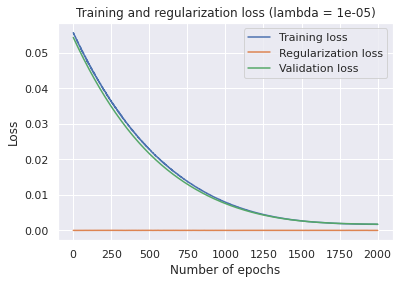

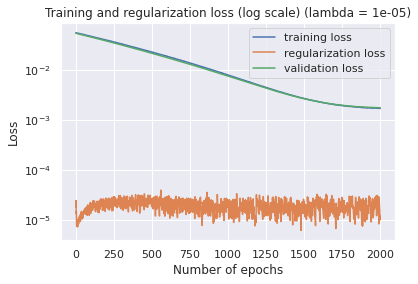

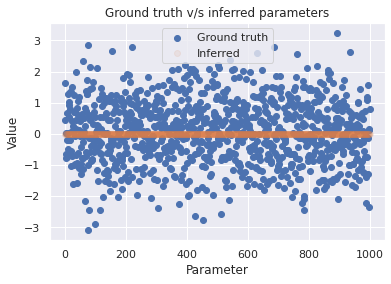

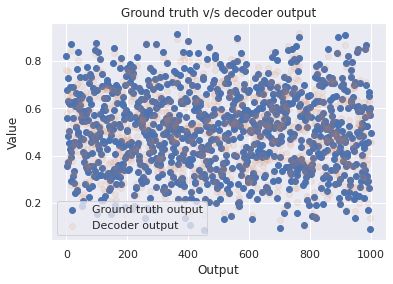

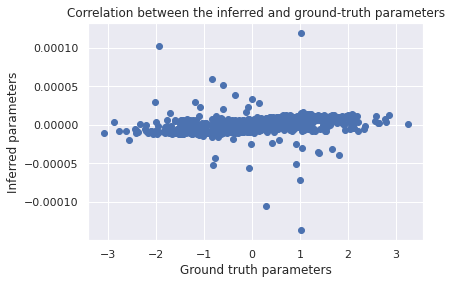

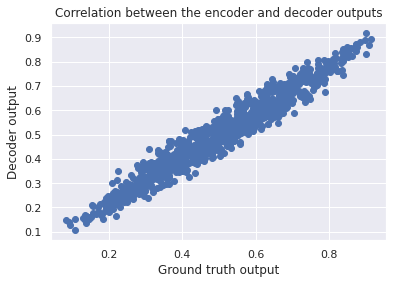

In [29]:
model_training_params = train_decoder_w_hidden(
    model_decoder_5_norm, loss_fn, n_epochs=num_epochs, l_norm=5, n_lambda=0.1
)
evaluate_model(
    model=model_decoder_5_norm,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-5,
    corr_vals=[],
    corr_flag=False,
)

 21%|██        | 412/2000 [00:04<00:17, 90.29it/s]

iteration 400/2000 | train loss: 0.010416466742753983


 41%|████      | 817/2000 [00:09<00:13, 86.85it/s]

iteration 800/2000 | train loss: 0.0025816275738179684


 61%|██████    | 1215/2000 [00:14<00:08, 88.94it/s]

iteration 1200/2000 | train loss: 0.0013472296996042132


 81%|████████  | 1614/2000 [00:18<00:04, 84.87it/s]

iteration 1600/2000 | train loss: 0.0009194960002787411


100%|██████████| 2000/2000 [00:23<00:00, 84.52it/s]


iteration 2000/2000 | train loss: 0.0008096116362139583


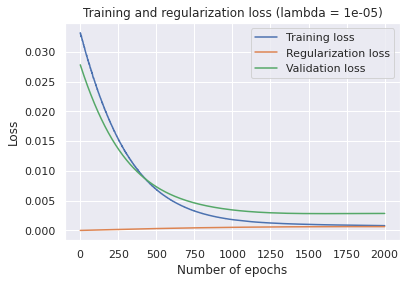

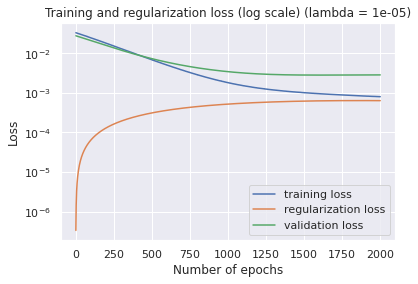

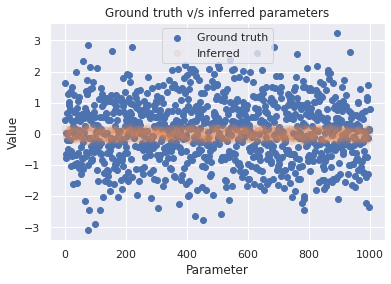

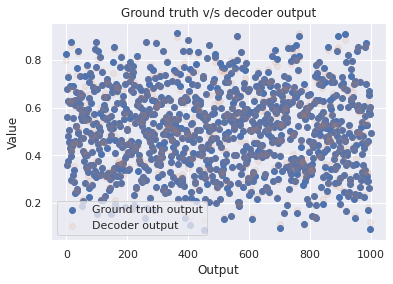

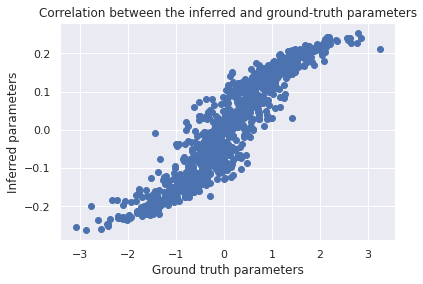

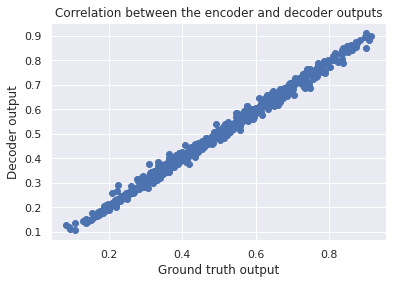

In [30]:
model_training_params = train_decoder_w_hidden(
    model_decoder_5_norm_1e3, loss_fn, n_epochs=num_epochs, l_norm=5, n_lambda=0.001
)
evaluate_model(
    model=model_decoder_5_norm_1e3,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-5,
    corr_vals=[],
    corr_flag=False,
)

 20%|██        | 410/2000 [00:04<00:21, 72.98it/s]

iteration 400/2000 | train loss: 0.03325136750936508


 41%|████      | 814/2000 [00:09<00:13, 89.27it/s]

iteration 800/2000 | train loss: 0.012823652476072311


 61%|██████    | 1214/2000 [00:14<00:09, 85.55it/s]

iteration 1200/2000 | train loss: 0.003604276105761528


 81%|████████  | 1617/2000 [00:18<00:04, 87.26it/s]

iteration 1600/2000 | train loss: 0.0009359684190712869


100%|██████████| 2000/2000 [00:23<00:00, 84.94it/s]


iteration 2000/2000 | train loss: 0.00039109555655159056


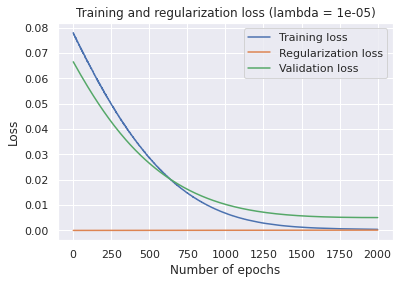

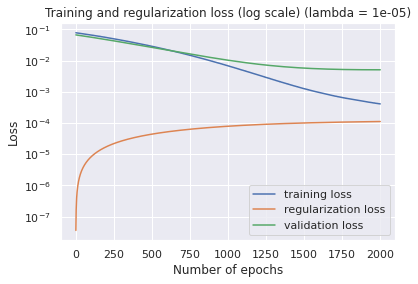

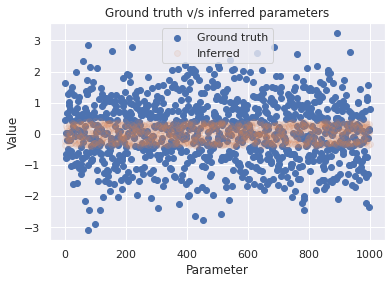

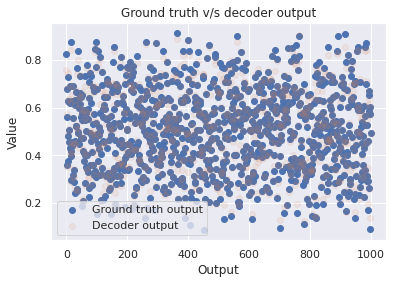

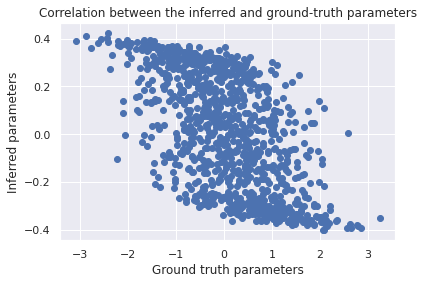

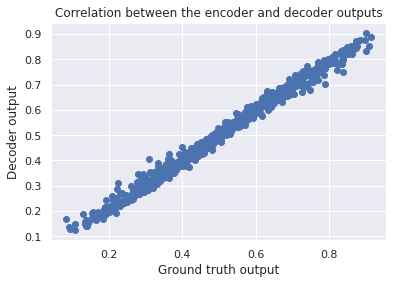

In [31]:
model_training_params = train_decoder_w_hidden(
    model_decoder_5_norm_1e4, loss_fn, n_epochs=num_epochs, l_norm=5, n_lambda=0.0001
)
evaluate_model(
    model=model_decoder_5_norm_1e4,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-5,
    corr_vals=[],
    corr_flag=False,
)

 21%|██        | 416/2000 [00:04<00:20, 77.12it/s]

iteration 400/2000 | train loss: 0.002060758648440242


 41%|████      | 813/2000 [00:09<00:13, 88.11it/s]

iteration 800/2000 | train loss: 0.0006052065291441977


 60%|██████    | 1210/2000 [00:14<00:09, 83.73it/s]

iteration 1200/2000 | train loss: 0.0002829476143233478


 80%|████████  | 1610/2000 [00:18<00:04, 88.46it/s]

iteration 1600/2000 | train loss: 7.267640467034653e-05


100%|██████████| 2000/2000 [00:23<00:00, 84.64it/s]


iteration 2000/2000 | train loss: 2.2168769646668807e-05


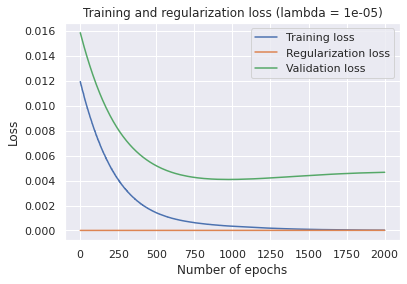

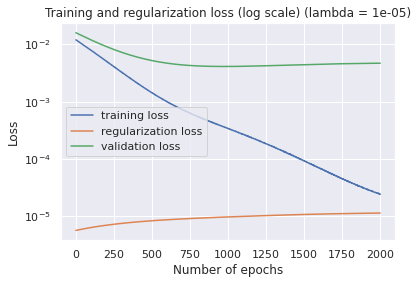

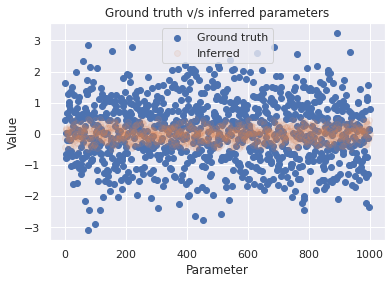

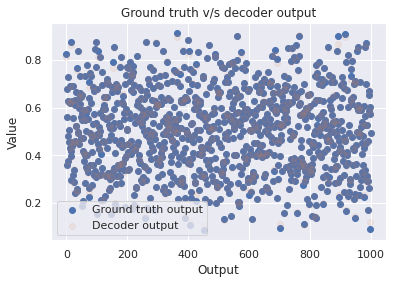

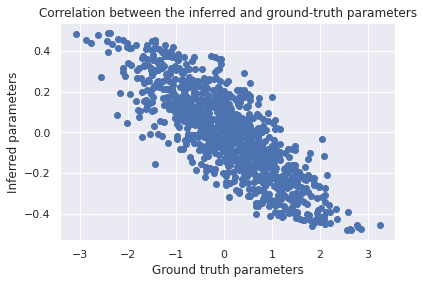

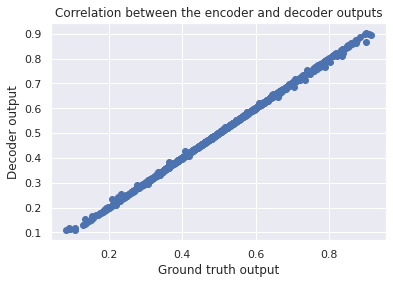

In [33]:
model_training_params = train_decoder_w_hidden(
    model_decoder_5_norm_1e5, loss_fn, n_epochs=num_epochs, l_norm=5, n_lambda=0.00001
)
evaluate_model(
    model=model_decoder_5_norm_1e5,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-5,
    corr_vals=[],
    corr_flag=False,
)

 21%|██        | 414/2000 [00:04<00:18, 87.15it/s]

iteration 400/2000 | train loss: 0.014452489092946053


 41%|████      | 817/2000 [00:09<00:13, 86.02it/s]

iteration 800/2000 | train loss: 0.005682460032403469


 61%|██████    | 1217/2000 [00:14<00:09, 86.70it/s]

iteration 1200/2000 | train loss: 0.0017086834413930774


 80%|████████  | 1606/2000 [00:18<00:04, 88.21it/s]

iteration 1600/2000 | train loss: 0.0003821452846750617


100%|██████████| 2000/2000 [00:23<00:00, 84.76it/s]


iteration 2000/2000 | train loss: 0.00011112384527223185


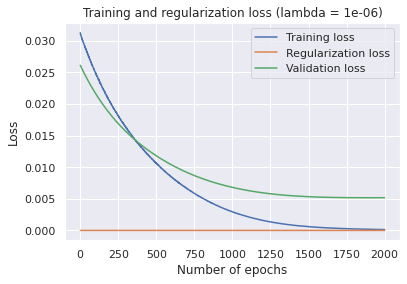

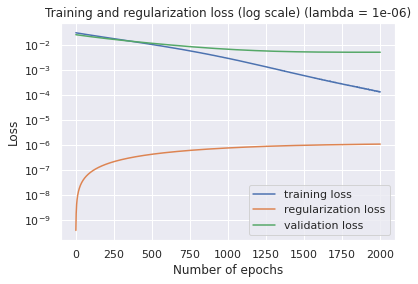

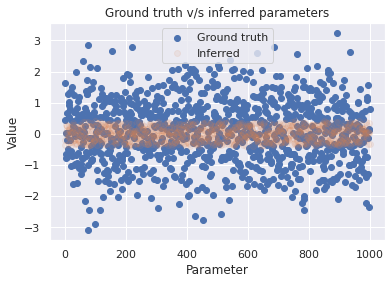

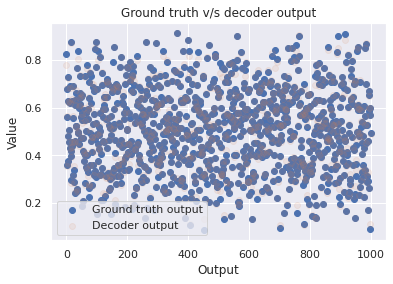

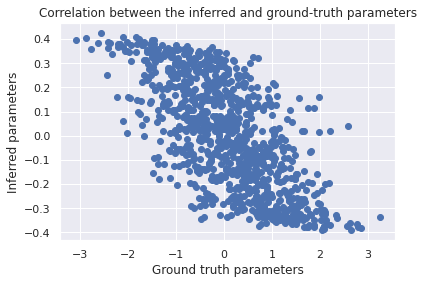

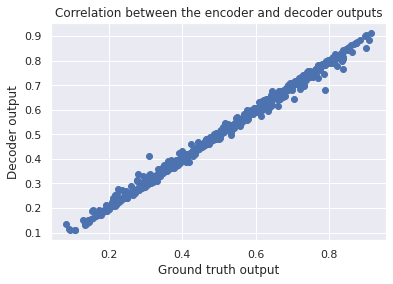

In [34]:
model_training_params = train_decoder_w_hidden(
    model_decoder_5_norm_1e6, loss_fn, n_epochs=num_epochs, l_norm=5, n_lambda=0.000001
)
evaluate_model(
    model=model_decoder_5_norm_1e6,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-6,
    corr_vals=[],
    corr_flag=False,
)

 21%|██        | 415/2000 [00:04<00:18, 87.40it/s]

iteration 400/2000 | train loss: 0.012768864631652832


 41%|████      | 817/2000 [00:09<00:14, 79.34it/s]

iteration 800/2000 | train loss: 0.003856226336210966


 61%|██████    | 1211/2000 [00:14<00:09, 87.52it/s]

iteration 1200/2000 | train loss: 0.0010079378262162209


 80%|████████  | 1609/2000 [00:19<00:04, 84.36it/s]

iteration 1600/2000 | train loss: 0.00025283018476329744


100%|██████████| 2000/2000 [00:23<00:00, 84.24it/s]


iteration 2000/2000 | train loss: 6.339956598822027e-05


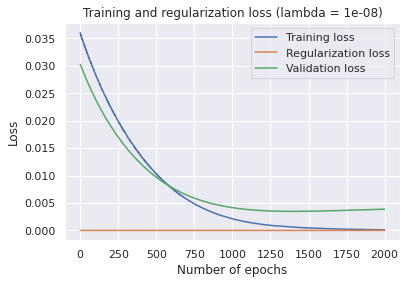

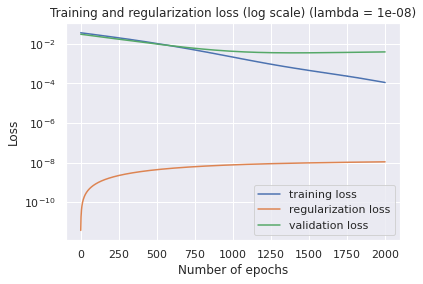

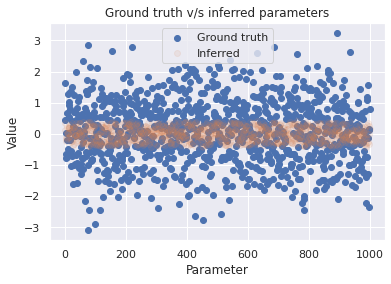

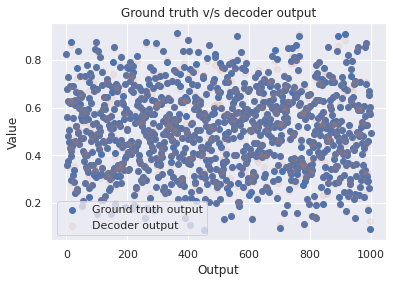

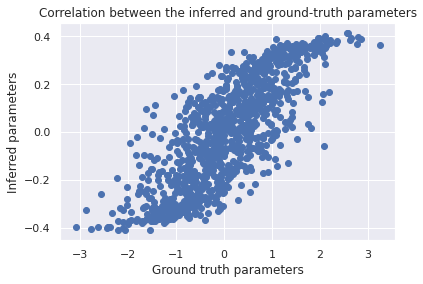

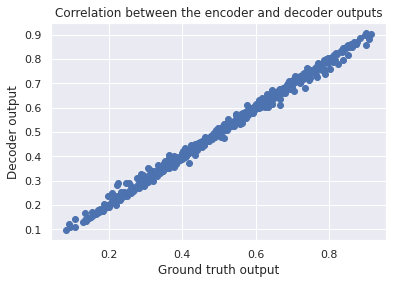

In [35]:
model_training_params = train_decoder_w_hidden(
    model_decoder_5_norm_1e8,
    loss_fn,
    n_epochs=num_epochs,
    l_norm=5,
    n_lambda=0.00000001,
)
evaluate_model(
    model=model_decoder_5_norm_1e8,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-8,
    corr_vals=[],
    corr_flag=False,
)

# Other P-norms with same variance for the hidden activity initialization

In [37]:
model_decoder_same_var_5norm_1e8 = neuron_unit_decoder_w_hidden_same_var().to(device)

 21%|██        | 411/2000 [00:04<00:17, 89.28it/s]

iteration 400/2000 | train loss: 0.016957974061369896


 41%|████      | 817/2000 [00:09<00:13, 85.53it/s]

iteration 800/2000 | train loss: 0.0068847788497805595


 61%|██████    | 1212/2000 [00:14<00:08, 88.44it/s]

iteration 1200/2000 | train loss: 0.0029559300746768713


 81%|████████  | 1613/2000 [00:18<00:04, 89.01it/s]

iteration 1600/2000 | train loss: 0.0017869732109829783


100%|██████████| 2000/2000 [00:23<00:00, 85.62it/s]


iteration 2000/2000 | train loss: 0.0016922233626246452


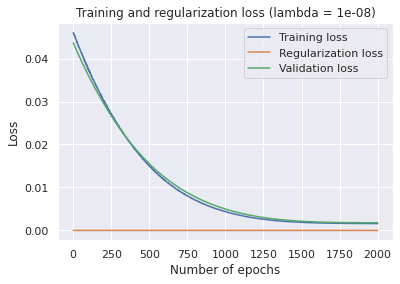

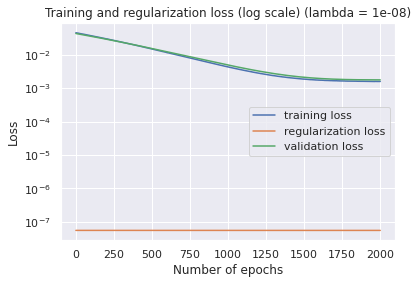

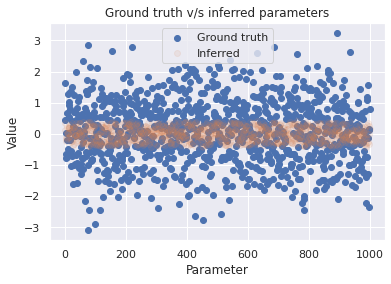

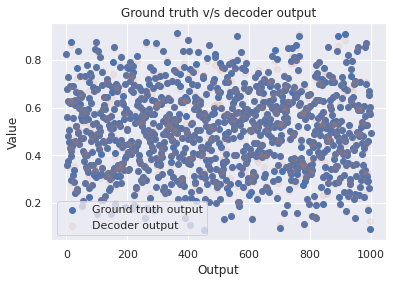

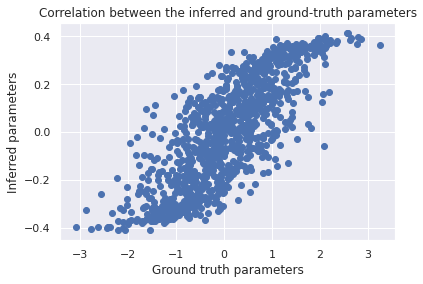

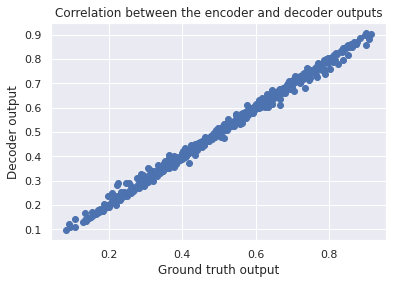

In [38]:
model_training_params = train_decoder_w_hidden(
    model_decoder_same_var_5norm_1e8,
    loss_fn,
    n_epochs=num_epochs,
    l_norm=5,
    n_lambda=0.00000001,
)
evaluate_model(
    model=model_decoder_5_norm_1e8,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-8,
    corr_vals=[],
    corr_flag=False,
)

 20%|██        | 410/2000 [00:04<00:18, 86.76it/s]

iteration 400/2000 | train loss: 0.0147949093952775


 40%|████      | 809/2000 [00:09<00:13, 86.55it/s]

iteration 800/2000 | train loss: 0.005358217749744654


 61%|██████    | 1217/2000 [00:14<00:09, 82.32it/s]

iteration 1200/2000 | train loss: 0.002133043250069022


 80%|████████  | 1610/2000 [00:19<00:04, 86.16it/s]

iteration 1600/2000 | train loss: 0.001448138034902513


100%|██████████| 2000/2000 [00:23<00:00, 84.24it/s]


iteration 2000/2000 | train loss: 0.0015555163845419884


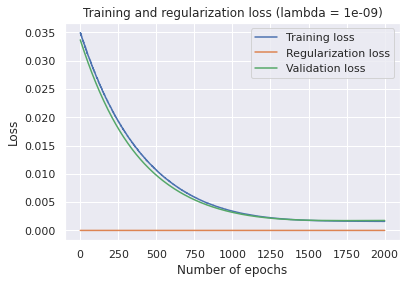

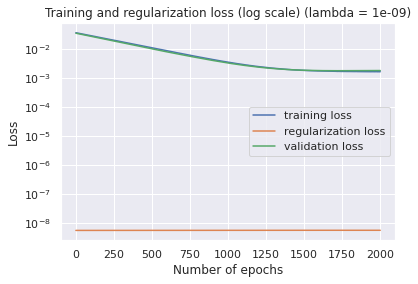

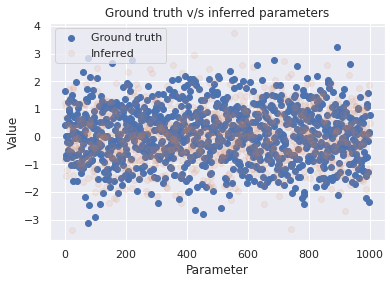

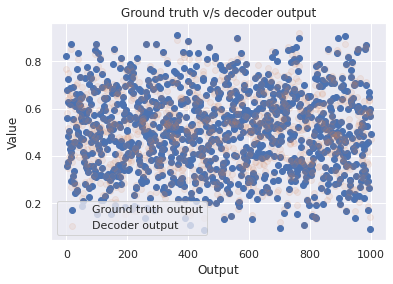

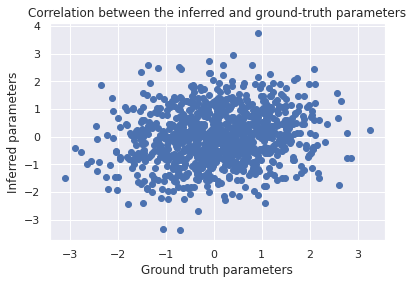

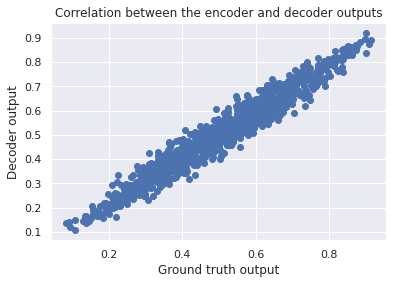

In [40]:
model_decoder_same_var_5norm_1e9 = neuron_unit_decoder_w_hidden_same_var().to(device)

model_training_params = train_decoder_w_hidden(
    model_decoder_same_var_5norm_1e9,
    loss_fn,
    n_epochs=num_epochs,
    l_norm=5,
    n_lambda=0.000000001,
)
evaluate_model(
    model=model_decoder_same_var_5norm_1e9,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-9,
    corr_vals=[],
    corr_flag=False,
)

# Resolving redundancy for the weights of the hidden activity paramaters

Here the weight of the hidden activity parameter is fixed to 1 because the model is  
already learning the value of the hidden parameters through backpropagation. Hence, having one more weight paramater, would make the problem redundant 


In [41]:
class neuron_unit_decoder_w_hidden_init_fix(nn.Module):
    """
    - Has the same variance as the input features
    - Has the weights forn the hidden acitvity as 1, to remove the
    redundancy
    """

    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 1)
        self.act1 = nn.Sigmoid()
        self.h_activity_vec = torch.nn.Parameter(torch.normal(0, 1, size=(1000, 1)))

        # Initialize the weights of the hidden vector by 1 (last synapse)
        nn.init.constant_(self.linear1.weight[0, -1].data, 1)

    def forward(self, x):
        input_wo_time = x[:, :-1].to(device)
        timepoint = x[:, -1].to(device)

        input_to_network = torch.cat(
            (input_wo_time, self.h_activity_vec[timepoint.long() - 1]), dim=1
        ).to(device)  # [1,10]

        x = input_to_network
        x = self.linear1(x)
        x = self.act1(x)
        return x

In [43]:
model_decoder_initfix = neuron_unit_decoder_w_hidden_init_fix().to(device)
print(model_decoder_initfix)

print(
    f"Value of the hidden activity paramater weight: {model_decoder_initfix.linear1.weight[0,-1].data}"
)

neuron_unit_decoder_w_hidden_init_fix(
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (act1): Sigmoid()
)
Value of the hidden activity paramater weight: 1.0


In [44]:
def train_decoder_w_hidden(
    model, loss_fn, n_lambda, l_norm, n_epochs=50, learning_rate=1e-4
):

    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    model_training_params = dict()
    model_training_params["loss_vals"] = []
    model_training_params["l2_loss_vals"] = []
    model_training_params["validation_loss"] = []
    model_training_params["n_epochs"] = n_epochs

    for i in tqdm(range(n_epochs)):
        epoch_loss = []
        epoch_l2_loss = []
        epoch_val_loss = []

        for xb, yb in train_dl_hidden:
            out = model(xb).to(device)
            yb = yb.to(device)
            loss = loss_fn(out, yb)

            norm = torch.linalg.vector_norm(model.h_activity_vec, ord=l_norm)
            l2_loss = n_lambda * norm
            # Regularization of hidden param vec
            loss = loss + l2_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            epoch_l2_loss.append(l2_loss.item())

        with torch.no_grad():
            model.eval()
            for xb, yb in test_dl_hidden:
                pred = model(xb).to(device)
                yb = yb.to(device)
                val_loss = loss_fn(pred, yb)
                epoch_val_loss.append(val_loss.item())

        model_training_params["loss_vals"].append(sum(epoch_loss) / len(epoch_loss))
        model_training_params["l2_loss_vals"].append(
            sum(epoch_l2_loss) / len(epoch_l2_loss)
        )
        model_training_params["validation_loss"].append(
            sum(epoch_val_loss) / len(epoch_val_loss)
        )

        if (i + 1) % (n_epochs // 5) == 0:
            print(f"iteration {i + 1}/{n_epochs} | train loss: {loss.item():}")

    return model_training_params

 20%|██        | 1210/6000 [00:14<00:55, 86.48it/s]

iteration 1200/6000 | train loss: 0.013632562011480331


 40%|████      | 2413/6000 [00:28<00:44, 81.17it/s]

iteration 2400/6000 | train loss: 0.002258479129523039


 60%|██████    | 3612/6000 [00:42<00:26, 89.18it/s]

iteration 3600/6000 | train loss: 0.0015006513567641377


 80%|████████  | 4815/6000 [00:56<00:13, 88.93it/s]

iteration 4800/6000 | train loss: 0.0013035793090239167


100%|██████████| 6000/6000 [01:10<00:00, 84.75it/s]


iteration 6000/6000 | train loss: 0.0009703465038910508


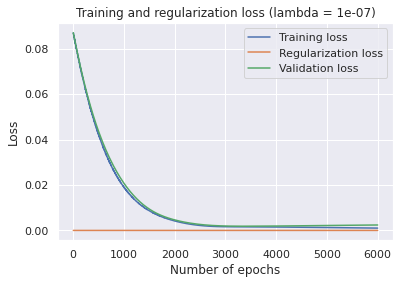

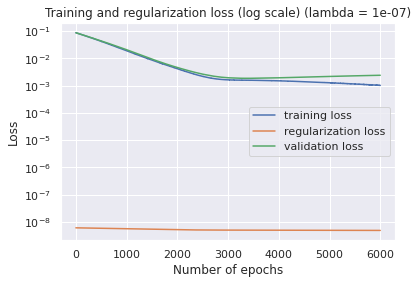

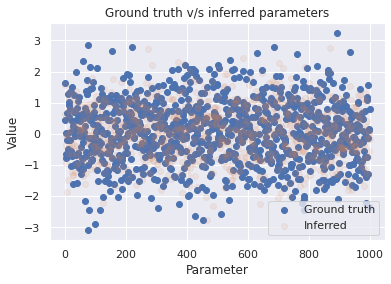

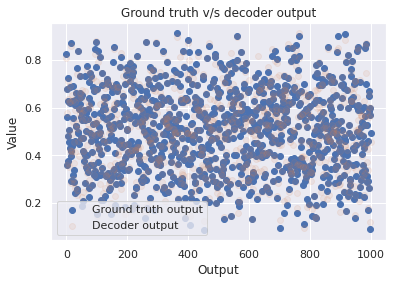

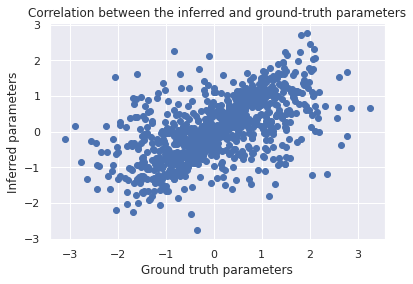

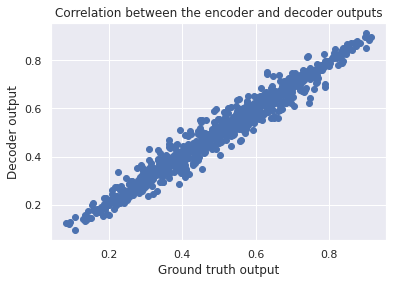

In [45]:
model_training_params = train_decoder_w_hidden(
    model_decoder_initfix, loss_fn, n_epochs=6000, l_norm=5, n_lambda=0.000000001
)
evaluate_model(
    model=model_decoder_initfix,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-7,
    corr_vals=[],
    corr_flag=False,
)

## Model: 5-norm with $\lambda$ = $10 ^{-4}$

In [46]:
model_decoder_p5_10e4 = neuron_unit_decoder_w_hidden_init_fix().to(device)
model_training_params = train_decoder_w_hidden(
    model_decoder_p5_10e4, loss_fn, l_norm=5, n_epochs=6000, n_lambda=10e-4
)

 20%|██        | 1213/6000 [00:14<00:55, 86.13it/s]

iteration 1200/6000 | train loss: 0.01848771423101425


 40%|████      | 2417/6000 [00:28<00:43, 81.73it/s]

iteration 2400/6000 | train loss: 0.006430022418498993


 60%|██████    | 3605/6000 [00:42<00:27, 88.41it/s]

iteration 3600/6000 | train loss: 0.004930740222334862


 80%|████████  | 4813/6000 [00:57<00:13, 86.17it/s]

iteration 4800/6000 | train loss: 0.003399202134460211


100%|██████████| 6000/6000 [01:11<00:00, 84.36it/s]

iteration 6000/6000 | train loss: 0.0019611401949077845


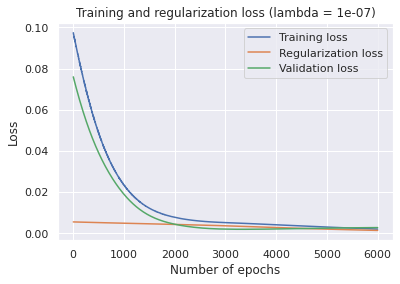

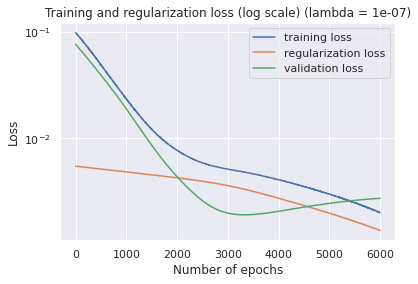

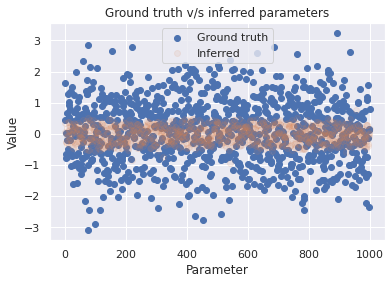

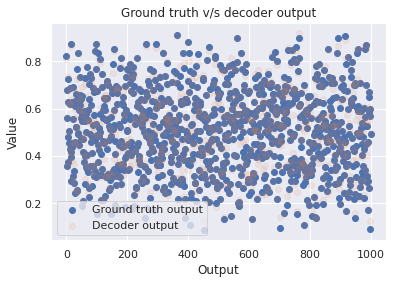

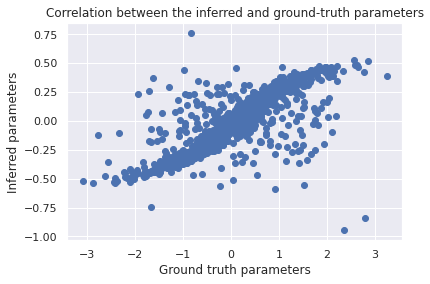

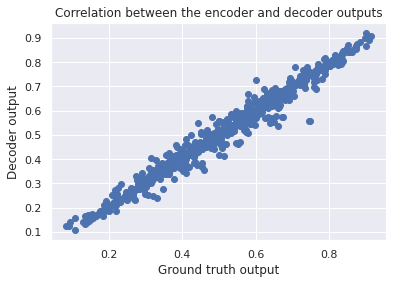

In [47]:
evaluate_model(
    model=model_decoder_p5_10e4,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=1e-7,
    corr_vals=[],
    corr_flag=False,
)

## Model: 2-norm with $\lambda$ = $10 ^{-4}$

In [48]:
model_decoder_p2_10e4 = neuron_unit_decoder_w_hidden_init_fix().to(device)
model_training_params = train_decoder_w_hidden(
    model_decoder_p2_10e4, loss_fn, l_norm=2, n_epochs=6000, n_lambda=10e-4
)

 20%|██        | 1213/6000 [00:14<00:56, 85.32it/s]

iteration 1200/6000 | train loss: 0.03439135476946831


 40%|████      | 2408/6000 [00:28<00:53, 67.71it/s]

iteration 2400/6000 | train loss: 0.020040009170770645


 60%|██████    | 3613/6000 [00:42<00:27, 87.09it/s]

iteration 3600/6000 | train loss: 0.01282256469130516


 80%|████████  | 4817/6000 [00:56<00:13, 85.10it/s]

iteration 4800/6000 | train loss: 0.007957050576806068


100%|██████████| 6000/6000 [01:10<00:00, 85.70it/s]

iteration 6000/6000 | train loss: 0.005370608065277338


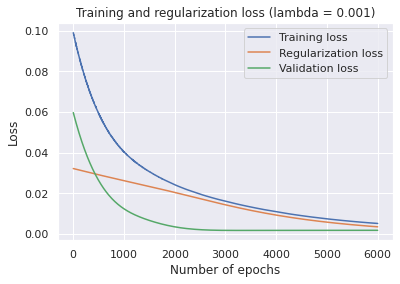

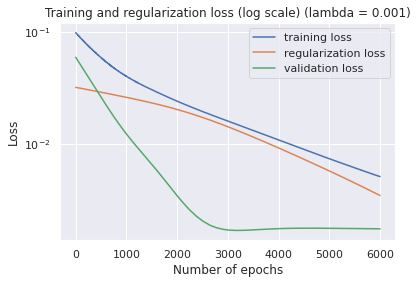

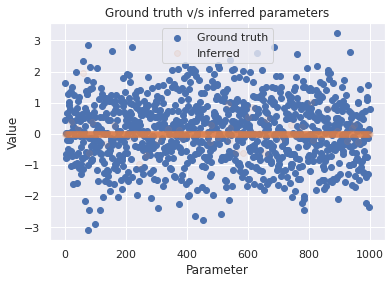

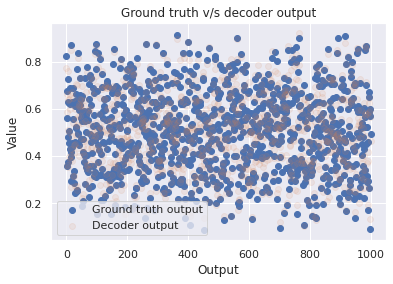

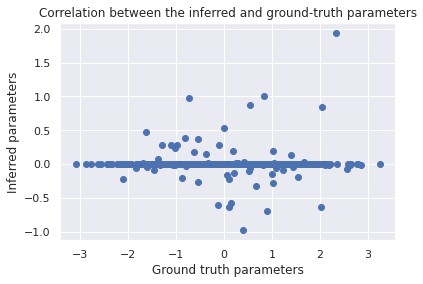

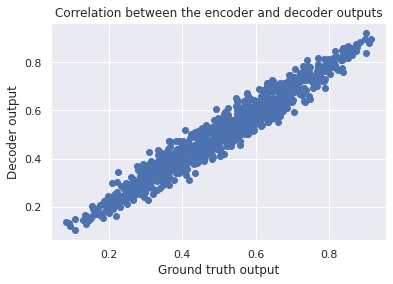

In [49]:
evaluate_model(
    model=model_decoder_p2_10e4,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=10e-4,
    corr_vals=[],
    corr_flag=False,
)

## Model: 2-norm with $\lambda$ = $10 ^{-8}$

In [50]:
model_decoder_p2_10e8 = neuron_unit_decoder_w_hidden_init_fix().to(device)
model_training_params = train_decoder_w_hidden(
    model_decoder_p2_10e4, loss_fn, l_norm=2, n_epochs=6000, n_lambda=10e-8
)

 20%|██        | 1215/6000 [00:14<00:56, 85.25it/s]

iteration 1200/6000 | train loss: 0.0003061547758989036


 40%|████      | 2408/6000 [00:27<00:41, 85.70it/s]

iteration 2400/6000 | train loss: 0.00039706361712887883


 60%|██████    | 3614/6000 [00:42<00:27, 86.94it/s]

iteration 3600/6000 | train loss: 3.464087421889417e-05


 80%|████████  | 4811/6000 [00:56<00:13, 85.66it/s]

iteration 4800/6000 | train loss: 2.4545612177462317e-05


100%|██████████| 6000/6000 [01:10<00:00, 85.62it/s]

iteration 6000/6000 | train loss: 1.587907377142983e-06


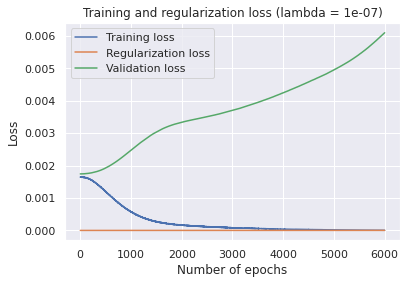

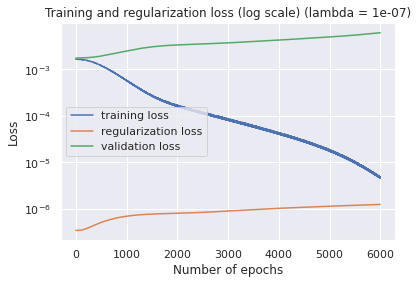

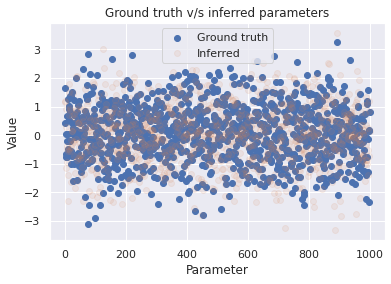

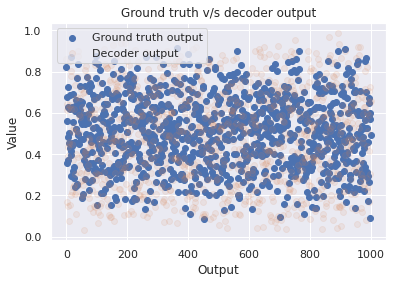

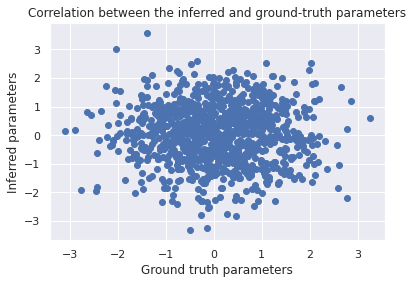

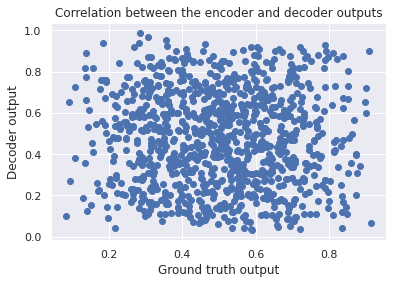

In [51]:
evaluate_model(
    model=model_decoder_p2_10e8,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=10e-8,
    corr_vals=[],
    corr_flag=False,
)

## Model: 2-norm with $\lambda$ = $10 ^{-6}$

In [52]:
model_decoder_p2_10e6 = neuron_unit_decoder_w_hidden_init_fix().to(device)
model_training_params = train_decoder_w_hidden(
    model_decoder_p2_10e6, loss_fn, l_norm=2, n_epochs=6000, n_lambda=10e-6
)

 20%|██        | 1209/6000 [00:14<00:59, 79.98it/s]

iteration 1200/6000 | train loss: 0.015872057527303696


 40%|████      | 2411/6000 [00:28<00:40, 88.34it/s]

iteration 2400/6000 | train loss: 0.002168152714148164


 60%|██████    | 3615/6000 [00:42<00:26, 90.18it/s]

iteration 3600/6000 | train loss: 0.001841069315560162


 80%|████████  | 4812/6000 [00:56<00:13, 85.89it/s]

iteration 4800/6000 | train loss: 0.0012993903364986181


100%|██████████| 6000/6000 [01:09<00:00, 85.93it/s]

iteration 6000/6000 | train loss: 0.0011163183953613043


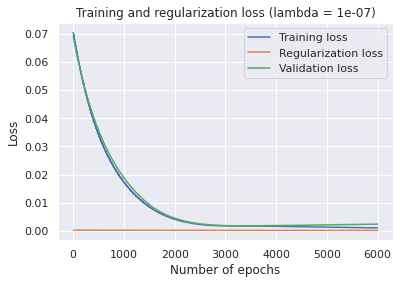

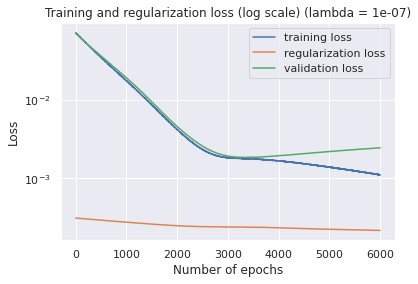

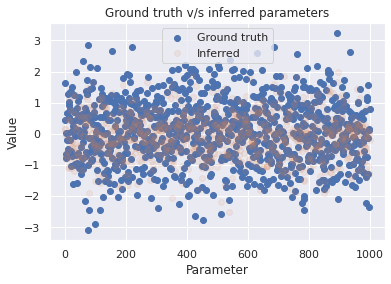

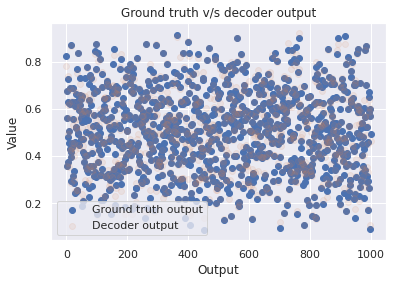

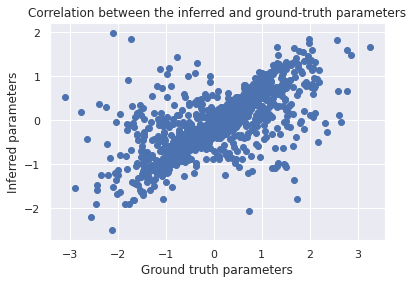

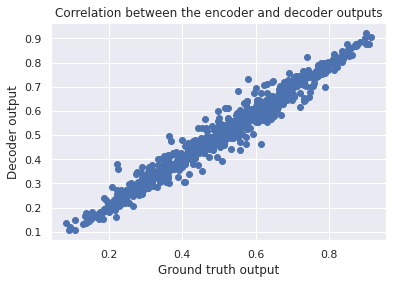

In [53]:
evaluate_model(
    model=model_decoder_p2_10e6,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=10e-8,
    corr_vals=[],
    corr_flag=False,
)

# Losses (training and validation) as a function of Lambda 

In [98]:
?run_lambda_variation

Signature: run_lambda_variation(lambda_list, norm, epochs)
Docstring:
Iterate over various lambda values and train decoder model 

Args:
    lambda_list: list containing values of lambda to be used
    norm: number deteremining which p norm to use for regularization (Ex: L1,L2, etc) 
    epochs: number of epochs to use for training 
    
Returns:
    train_loss: list containing the training loss values
    test_loss: list containing the training loss values
File:      ~/neuron-hidden-inference/src/helper_functions.py
Type:      function


In [58]:
lambda_list = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
lambda_list_extended = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 0]

## With 2-norm

In [63]:
train_L_lambda, test_L_lambda = run_lambda_variation(lambda_list, norm=2, epochs=6000)

 20%|██        | 1215/6000 [00:14<00:55, 86.24it/s]

iteration 1200/6000 | train loss: 0.2334340661764145


 40%|████      | 2417/6000 [00:28<00:39, 91.17it/s]

iteration 2400/6000 | train loss: 0.14570525288581848


 60%|██████    | 3618/6000 [00:41<00:26, 91.41it/s]

iteration 3600/6000 | train loss: 0.08450621366500854


 80%|████████  | 4809/6000 [00:55<00:13, 87.40it/s]

iteration 4800/6000 | train loss: 0.04295656085014343


100%|██████████| 6000/6000 [01:09<00:00, 86.15it/s]


iteration 6000/6000 | train loss: 0.01760188117623329
Trained model on lambda: 0.01



 20%|██        | 1213/6000 [00:13<00:53, 90.01it/s]

iteration 1200/6000 | train loss: 0.03782304376363754


 40%|████      | 2413/6000 [00:27<00:39, 90.48it/s]

iteration 2400/6000 | train loss: 0.018674911931157112


 60%|██████    | 3613/6000 [00:41<00:28, 84.20it/s]

iteration 3600/6000 | train loss: 0.010568142868578434


 80%|████████  | 4816/6000 [00:55<00:12, 91.57it/s]

iteration 4800/6000 | train loss: 0.005873847287148237


100%|██████████| 6000/6000 [01:09<00:00, 86.64it/s]


iteration 6000/6000 | train loss: 0.0031592801678925753
Trained model on lambda: 0.001



 20%|██        | 1210/6000 [00:14<00:53, 89.43it/s]

iteration 1200/6000 | train loss: 0.01634531468153


 40%|████      | 2415/6000 [00:28<00:47, 75.30it/s]

iteration 2400/6000 | train loss: 0.004758661147207022


 60%|██████    | 3609/6000 [00:42<00:27, 86.59it/s]

iteration 3600/6000 | train loss: 0.0033224686048924923


 80%|████████  | 4811/6000 [00:56<00:13, 88.50it/s]

iteration 4800/6000 | train loss: 0.002479502698406577


100%|██████████| 6000/6000 [01:10<00:00, 85.55it/s]


iteration 6000/6000 | train loss: 0.0018550879321992397
Trained model on lambda: 0.0001



 20%|██        | 1215/6000 [00:13<00:52, 91.46it/s]

iteration 1200/6000 | train loss: 0.012142674997448921


 40%|████      | 2415/6000 [00:27<00:40, 88.82it/s]

iteration 2400/6000 | train loss: 0.002496038330718875


 60%|██████    | 3616/6000 [00:42<00:26, 88.88it/s]

iteration 3600/6000 | train loss: 0.0016935148742049932


 80%|████████  | 4812/6000 [00:56<00:15, 77.44it/s]

iteration 4800/6000 | train loss: 0.0012892649974673986


100%|██████████| 6000/6000 [01:09<00:00, 85.78it/s]


iteration 6000/6000 | train loss: 0.0012808447936549783
Trained model on lambda: 1e-05



 20%|██        | 1211/6000 [00:14<00:54, 88.65it/s]

iteration 1200/6000 | train loss: 0.012857932597398758


 40%|████      | 2414/6000 [00:28<00:41, 85.75it/s]

iteration 2400/6000 | train loss: 0.0026664750184863806


 60%|██████    | 3610/6000 [00:42<00:26, 89.89it/s]

iteration 3600/6000 | train loss: 0.001602594624273479


 80%|████████  | 4811/6000 [00:56<00:13, 90.88it/s]

iteration 4800/6000 | train loss: 0.0013209162279963493


100%|██████████| 6000/6000 [01:09<00:00, 85.77it/s]


iteration 6000/6000 | train loss: 0.0009826315799728036
Trained model on lambda: 1e-06



 20%|██        | 1217/6000 [00:14<01:01, 78.32it/s]

iteration 1200/6000 | train loss: 0.01114360149949789


 40%|████      | 2413/6000 [00:28<00:41, 87.40it/s]

iteration 2400/6000 | train loss: 0.0019597583450376987


 60%|██████    | 3611/6000 [00:42<00:26, 89.16it/s]

iteration 3600/6000 | train loss: 0.001576705020852387


 80%|████████  | 4816/6000 [00:56<00:13, 86.31it/s]

iteration 4800/6000 | train loss: 0.0011122047435492277


100%|██████████| 6000/6000 [01:09<00:00, 85.80it/s]


iteration 6000/6000 | train loss: 0.000862104760017246
Trained model on lambda: 1e-07



 20%|██        | 1217/6000 [00:14<00:52, 90.25it/s]

iteration 1200/6000 | train loss: 0.009758617728948593


 40%|████      | 2415/6000 [00:27<00:40, 88.44it/s]

iteration 2400/6000 | train loss: 0.002260640263557434


 60%|██████    | 3613/6000 [00:41<00:31, 75.76it/s]

iteration 3600/6000 | train loss: 0.0013039202895015478


 80%|████████  | 4815/6000 [00:55<00:13, 90.70it/s]

iteration 4800/6000 | train loss: 0.0009991629049181938


100%|██████████| 6000/6000 [01:09<00:00, 86.36it/s]

iteration 6000/6000 | train loss: 0.000926608219742775
Trained model on lambda: 1e-08



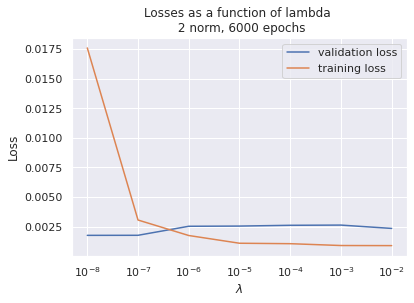

In [65]:
plot_lambda_vs_loss(lambda_list, test_L_lambda, train_L_lambda, norm=2, epochs=6000)

## With 5-norm

In [68]:
train_L_lambda, test_L_lambda = run_lambda_variation(lambda_list, norm=5, epochs=6000)

 20%|██        | 1212/6000 [00:14<00:55, 85.75it/s]

iteration 1200/6000 | train loss: 0.055980369448661804


 40%|████      | 2417/6000 [00:28<00:40, 87.51it/s]

iteration 2400/6000 | train loss: 0.03680781275033951


 60%|██████    | 3605/6000 [00:42<00:26, 89.06it/s]

iteration 3600/6000 | train loss: 0.024995213374495506


 80%|████████  | 4809/6000 [00:56<00:13, 86.44it/s]

iteration 4800/6000 | train loss: 0.01547518651932478


100%|██████████| 6000/6000 [01:10<00:00, 84.77it/s]


iteration 6000/6000 | train loss: 0.008096554316580296
Trained model on lambda: 0.01



 20%|██        | 1209/6000 [00:14<01:00, 79.28it/s]

iteration 1200/6000 | train loss: 0.0192777868360281


 40%|████      | 2417/6000 [00:28<00:39, 89.69it/s]

iteration 2400/6000 | train loss: 0.006793488748371601


 60%|██████    | 3616/6000 [00:42<00:26, 90.81it/s]

iteration 3600/6000 | train loss: 0.005038746166974306


 80%|████████  | 4811/6000 [00:56<00:13, 86.62it/s]

iteration 4800/6000 | train loss: 0.0036824336275458336


100%|██████████| 6000/6000 [01:10<00:00, 85.38it/s]


iteration 6000/6000 | train loss: 0.002510948572307825
Trained model on lambda: 0.001



 20%|██        | 1209/6000 [00:14<00:54, 87.19it/s]

iteration 1200/6000 | train loss: 0.014050153084099293


 40%|████      | 2411/6000 [00:28<00:40, 87.79it/s]

iteration 2400/6000 | train loss: 0.002871055155992508


 60%|██████    | 3613/6000 [00:42<00:29, 79.93it/s]

iteration 3600/6000 | train loss: 0.0017566822934895754


 80%|████████  | 4811/6000 [00:56<00:13, 90.49it/s]

iteration 4800/6000 | train loss: 0.0016687746392562985


100%|██████████| 6000/6000 [01:10<00:00, 84.96it/s]


iteration 6000/6000 | train loss: 0.001110958051867783
Trained model on lambda: 0.0001



 20%|██        | 1211/6000 [00:14<00:55, 86.68it/s]

iteration 1200/6000 | train loss: 0.01419783290475607


 40%|████      | 2412/6000 [00:28<00:40, 88.87it/s]

iteration 2400/6000 | train loss: 0.003269826527684927


 60%|██████    | 3616/6000 [00:42<00:26, 88.71it/s]

iteration 3600/6000 | train loss: 0.0015949287917464972


 80%|████████  | 4815/6000 [00:56<00:13, 88.79it/s]

iteration 4800/6000 | train loss: 0.0014935203362256289


100%|██████████| 6000/6000 [01:10<00:00, 85.23it/s]


iteration 6000/6000 | train loss: 0.00114381592720747
Trained model on lambda: 1e-05



 20%|██        | 1214/6000 [00:14<00:54, 87.76it/s]

iteration 1200/6000 | train loss: 0.014234866015613079


 40%|████      | 2410/6000 [00:28<00:42, 83.67it/s]

iteration 2400/6000 | train loss: 0.0025194573681801558


 60%|██████    | 3615/6000 [00:42<00:27, 85.74it/s]

iteration 3600/6000 | train loss: 0.001613279222510755


 80%|████████  | 4809/6000 [00:56<00:13, 88.70it/s]

iteration 4800/6000 | train loss: 0.0010489324340596795


100%|██████████| 6000/6000 [01:10<00:00, 85.13it/s]


iteration 6000/6000 | train loss: 0.0007819305174052715
Trained model on lambda: 1e-06



 20%|██        | 1212/6000 [00:14<00:52, 90.54it/s]

iteration 1200/6000 | train loss: 0.01425480842590332


 40%|████      | 2414/6000 [00:28<00:45, 78.88it/s]

iteration 2400/6000 | train loss: 0.002029298571869731


 60%|██████    | 3615/6000 [00:42<00:26, 88.58it/s]

iteration 3600/6000 | train loss: 0.0015778146917000413


 80%|████████  | 4818/6000 [00:56<00:13, 89.88it/s]

iteration 4800/6000 | train loss: 0.0009269749280065298


100%|██████████| 6000/6000 [01:09<00:00, 85.80it/s]


iteration 6000/6000 | train loss: 0.0009435696410946548
Trained model on lambda: 1e-07



 20%|██        | 1215/6000 [00:14<00:55, 86.61it/s]

iteration 1200/6000 | train loss: 0.012523151002824306


 40%|████      | 2417/6000 [00:28<00:40, 89.42it/s]

iteration 2400/6000 | train loss: 0.0018835891969501972


 60%|██████    | 3611/6000 [00:42<00:27, 88.16it/s]

iteration 3600/6000 | train loss: 0.0014278865419328213


 80%|████████  | 4816/6000 [00:56<00:14, 81.02it/s]

iteration 4800/6000 | train loss: 0.0011202468303963542


100%|██████████| 6000/6000 [01:10<00:00, 85.38it/s]

iteration 6000/6000 | train loss: 0.0009045309852808714
Trained model on lambda: 1e-08



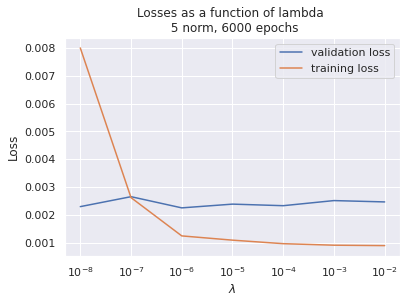

In [69]:
plot_lambda_vs_loss(lambda_list, test_L_lambda, train_L_lambda, norm=5, epochs=6000)

## Train for 20,000 iterations
Note: Training takes over 1 hour!

In [ ]:
train_L_lambda, test_L_lambda = run_lambda_variation(
    lambda_list_extended, norm=2, epochs=20000
)

In [ ]:
plot_lambda_vs_loss(
    lambda_list_extended, test_L_lambda, train_L_lambda, norm=2, epochs=20000
)

# Evolution of correlation between ground truth and inferred parameters over training
Calculating the coefficient of determination between the decoder hidden activity and the ground truth parameters defined as:

For our dataset containing n samples, where $y$ is the ground truth 

Residual sum of squares:
$SS_{res}=\sum_{i=1}^{n}(y_i-\hat{f}_i)^2$

Where $f_{i}$ are the fitted values from the models

Total sum of squares:
$SS_{total}=\sum_{i=1}^{n}(y_i-\bar{y})^2$

The coefficient is calculated as :

$R^2=1-\frac{SS_{res}}{SS_{total}}$

In [80]:
def train_decoder_w_hidden_w_corr(
    model, loss_fn, n_lambda, l_norm, n_epochs=50, learning_rate=1e-4
):

    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    model_training_params = dict()
    model_training_params["loss_vals"] = []
    model_training_params["l2_loss_vals"] = []
    model_training_params["validation_loss"] = []
    model_training_params["n_epochs"] = n_epochs
    model_training_params["corr_vals"] = []

    for i in tqdm(range(n_epochs)):
        epoch_loss = []
        epoch_l2_loss = []
        epoch_val_loss = []

        for xb, yb in train_dl_hidden:
            out = model(xb).to(device)
            yb = yb.to(device)
            loss = loss_fn(out, yb)

            norm = torch.linalg.vector_norm(model.h_activity_vec, ord=l_norm)

            l2_loss = n_lambda * norm

            # regularization of hidden param vec
            loss = loss + l2_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            epoch_l2_loss.append(l2_loss.item())

        with torch.no_grad():
            model.eval()
            for xb, yb in test_dl_hidden:
                pred = model(xb).to(device)
                yb = yb.to(device)
                val_loss = loss_fn(pred, yb)
                epoch_val_loss.append(val_loss.item())

        corr = r2_loss(model.h_activity_vec, datagen.original)
        model_training_params["corr_vals"].append(corr)

        model_training_params["loss_vals"].append(sum(epoch_loss) / len(epoch_loss))
        model_training_params["l2_loss_vals"].append(
            sum(epoch_l2_loss) / len(epoch_l2_loss)
        )
        model_training_params["validation_loss"].append(
            sum(epoch_val_loss) / len(epoch_val_loss)
        )

        if (i + 1) % (n_epochs // 5) == 0:
            print(f"iteration {i + 1}/{n_epochs} | train loss: {loss.item():}")

    return model_training_params

 20%|██        | 1209/6000 [00:15<00:56, 84.22it/s]

iteration 1200/6000 | train loss: 0.01948450691998005


 40%|████      | 2412/6000 [00:30<00:42, 83.94it/s]

iteration 2400/6000 | train loss: 0.006863993592560291


 60%|██████    | 3609/6000 [00:44<00:34, 68.44it/s]

iteration 3600/6000 | train loss: 0.004624270834028721


 80%|████████  | 4814/6000 [00:59<00:14, 84.27it/s]

iteration 4800/6000 | train loss: 0.0035427743569016457


100%|██████████| 6000/6000 [01:14<00:00, 80.56it/s]


iteration 6000/6000 | train loss: 0.0023598300758749247


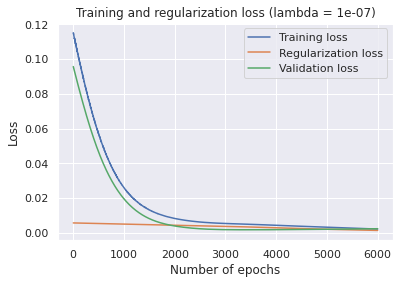

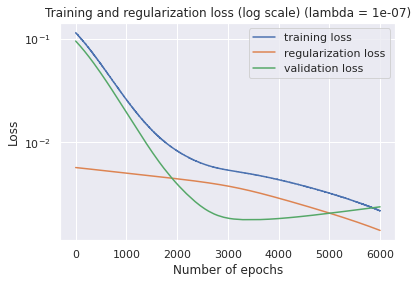

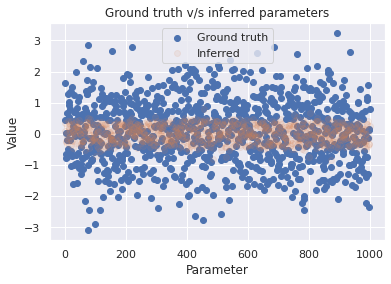

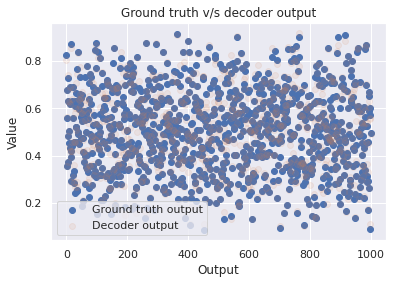

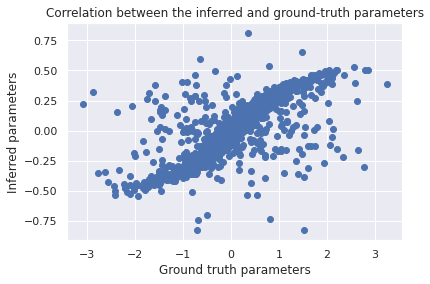

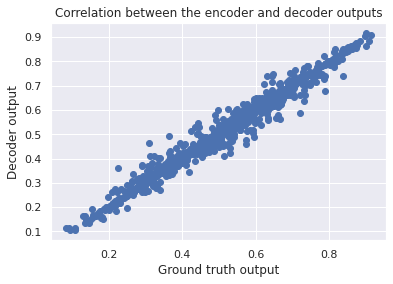

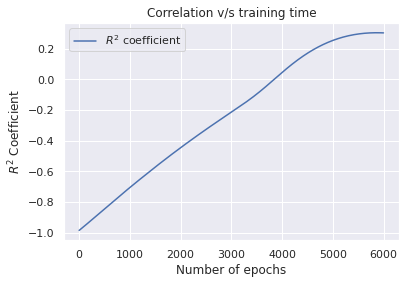

In [81]:
model_decoder_p5_10e4_corr = neuron_unit_decoder_w_hidden_init_fix().to(device)

model_training_params = train_decoder_w_hidden_w_corr(
    model_decoder_p5_10e4_corr, loss_fn, l_norm=5, n_epochs=6000, n_lambda=10e-4
)

evaluate_model(
    model=model_decoder_p5_10e4_corr,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=10e-8,
)

 20%|██        | 1215/6000 [00:15<00:58, 82.05it/s]

iteration 1200/6000 | train loss: 0.012771026231348515


 40%|████      | 2409/6000 [00:30<00:44, 81.23it/s]

iteration 2400/6000 | train loss: 0.002297554863616824


 60%|██████    | 3612/6000 [00:45<00:29, 82.26it/s]

iteration 3600/6000 | train loss: 0.0015164418146014214


 80%|████████  | 4809/6000 [01:00<00:14, 83.02it/s]

iteration 4800/6000 | train loss: 0.0013118896167725325


100%|██████████| 6000/6000 [01:15<00:00, 79.38it/s]


iteration 6000/6000 | train loss: 0.0010723614832386374


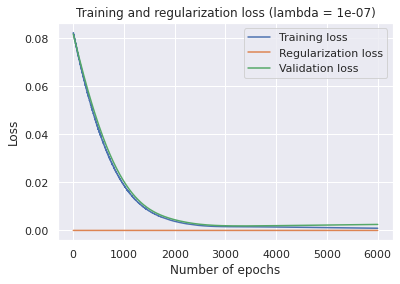

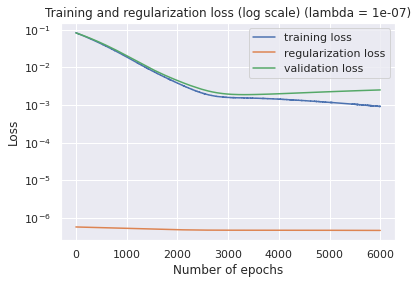

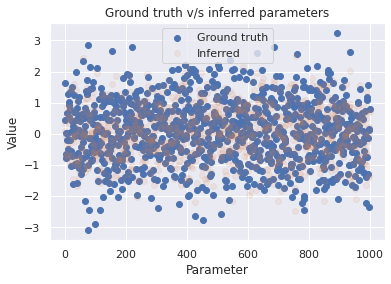

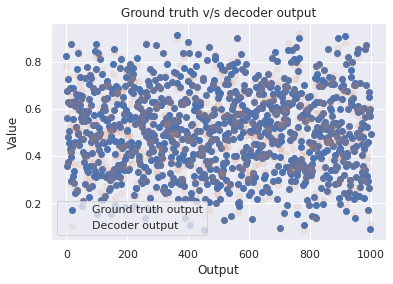

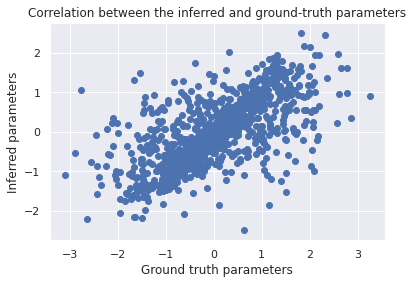

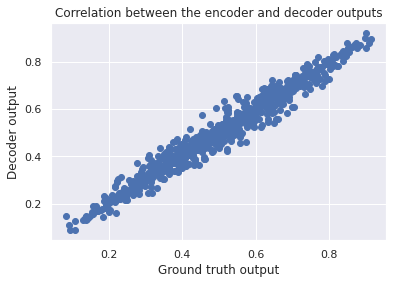

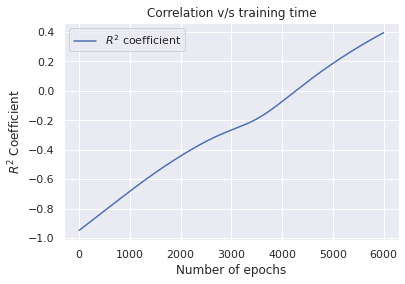

In [82]:
model_decoder_p5_10e8_corr = neuron_unit_decoder_w_hidden_init_fix().to(device)
model_training_params = train_decoder_w_hidden_w_corr(
    model_decoder_p5_10e8_corr, loss_fn, l_norm=5, n_epochs=6000, n_lambda=10e-8
)

evaluate_model(
    model=model_decoder_p5_10e8_corr,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=10e-8,
)

 20%|██        | 2411/12000 [00:30<01:55, 82.76it/s]

iteration 2400/12000 | train loss: 0.0021819754038006067


 40%|████      | 4806/12000 [01:00<01:28, 81.30it/s]

iteration 4800/12000 | train loss: 0.0012707284186035395


 60%|██████    | 7212/12000 [01:30<00:57, 83.02it/s]

iteration 7200/12000 | train loss: 0.0004794478300027549


 80%|████████  | 9612/12000 [02:00<00:29, 81.48it/s]

iteration 9600/12000 | train loss: 0.0003559872566256672


100%|██████████| 12000/12000 [02:30<00:00, 79.56it/s]


iteration 12000/12000 | train loss: 4.33981440437492e-05


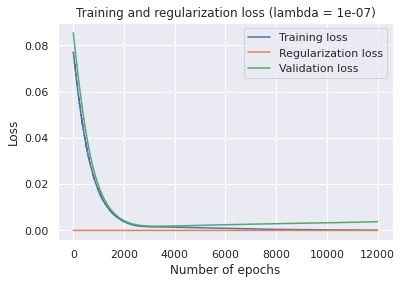

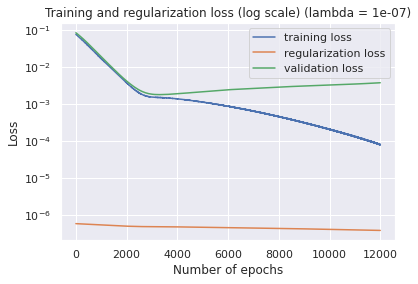

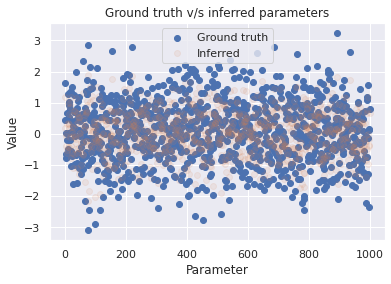

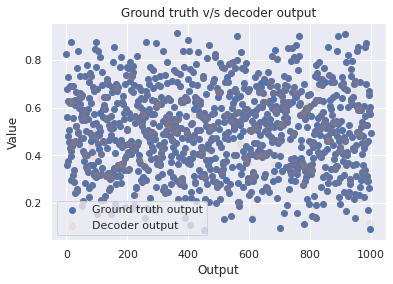

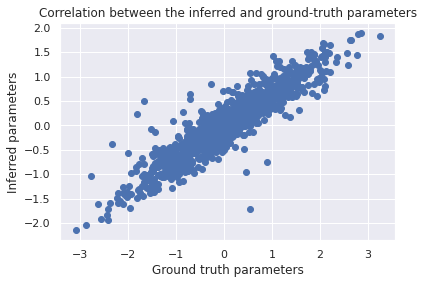

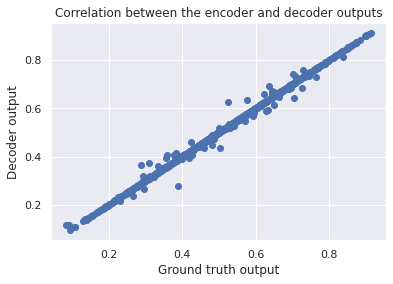

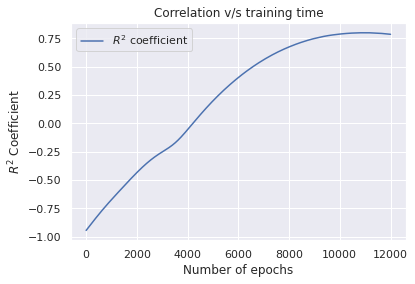

In [83]:
model_decoder_p5_10e8_corr = neuron_unit_decoder_w_hidden_init_fix().to(device)
model_training_params = train_decoder_w_hidden_w_corr(
    model_decoder_p5_10e8_corr, loss_fn, l_norm=5, n_epochs=12000, n_lambda=10e-8
)
evaluate_model(
    model=model_decoder_p5_10e8_corr,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=10e-8,
)

# Penalize variance across the hidden activity vector
Another method of achievieng regularization, by penalizing the variance of the hidden activity by comparing it to the ground truth variance. 

When the variance increases it is penalized to constrain its values. 


In [88]:
def train_decoder_w_hidden_w_var_penalty(
    model, loss_fn, n_lambda, l_norm, var_coeff, n_epochs=50, learning_rate=1e-4
):

    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    model_training_params = dict()
    model_training_params["loss_vals"] = []
    model_training_params["l2_loss_vals"] = []
    model_training_params["validation_loss"] = []
    model_training_params["n_epochs"] = n_epochs
    model_training_params["corr_vals"] = []

    gt_var = torch.var(datagen.original)

    for i in tqdm(range(n_epochs)):
        epoch_loss = []
        epoch_l2_loss = []
        epoch_val_loss = []

        for xb, yb in train_dl_hidden:
            out = model(xb).to(device)
            yb = yb.to(device)
            loss = loss_fn(out, yb)

            hidden_var = torch.var(model.h_activity_vec)
            var_diff = (hidden_var - gt_var) ** 2
            var_loss = torch.maximum(var_diff, torch.tensor(0))
            l2_loss = var_loss

            loss = (
                loss + var_loss * var_coeff
            )  # The coefficient is large, can go to inf

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            epoch_l2_loss.append(l2_loss.item())

        with torch.no_grad():
            model.eval()
            for xb, yb in test_dl_hidden:
                pred = model(xb).to(device)
                yb = yb.to(device)
                val_loss = loss_fn(pred, yb)
                epoch_val_loss.append(val_loss.item())

        corr = r2_loss(model.h_activity_vec, datagen.original)
        model_training_params["corr_vals"].append(corr)

        model_training_params["loss_vals"].append(sum(epoch_loss) / len(epoch_loss))
        model_training_params["l2_loss_vals"].append(
            sum(epoch_l2_loss) / len(epoch_l2_loss)
        )
        model_training_params["validation_loss"].append(
            sum(epoch_val_loss) / len(epoch_val_loss)
        )

        if (i + 1) % (n_epochs // 5) == 0:
            print(f"iteration {i + 1}/{n_epochs} | train loss: {loss.item():}")

    return model_training_params

 20%|██        | 2408/12000 [00:31<02:01, 78.79it/s]

iteration 2400/12000 | train loss: 0.002130907028913498


 40%|████      | 4813/12000 [01:03<01:35, 75.37it/s]

iteration 4800/12000 | train loss: 0.0012358635431155562


 60%|██████    | 7208/12000 [01:34<01:03, 75.69it/s]

iteration 7200/12000 | train loss: 0.0008451813482679427


 80%|████████  | 9609/12000 [02:06<00:33, 71.30it/s]

iteration 9600/12000 | train loss: 0.00035862383083440363


100%|██████████| 12000/12000 [02:38<00:00, 75.92it/s]


iteration 12000/12000 | train loss: 0.00021271109289955348


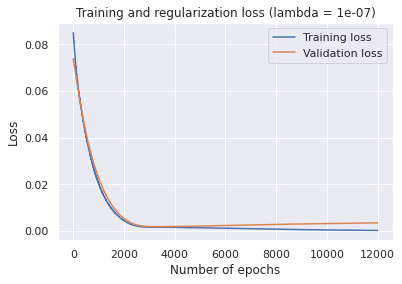

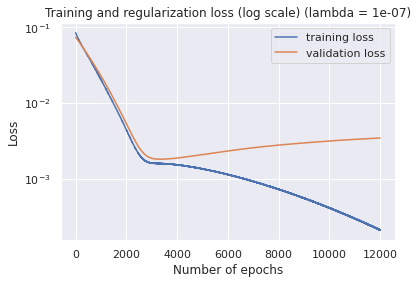

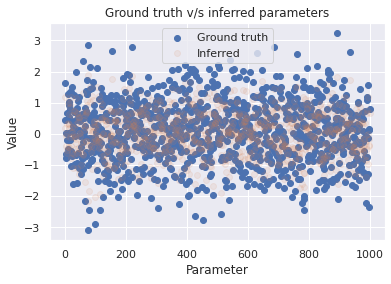

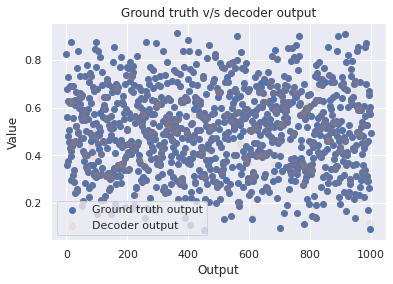

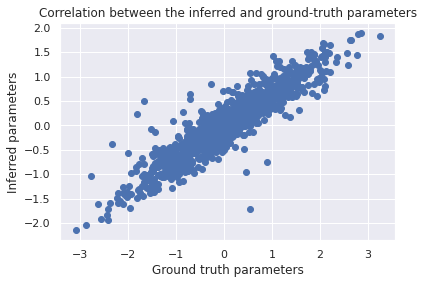

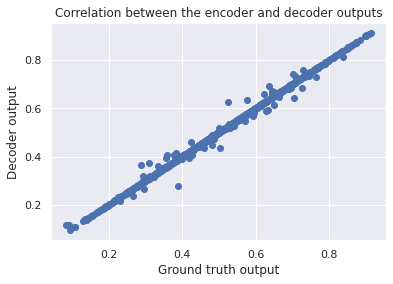

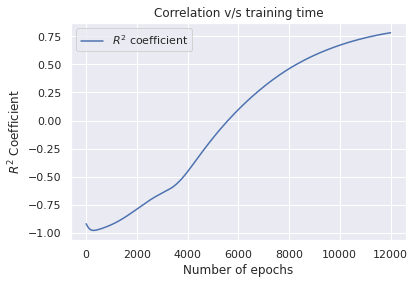

In [89]:
# Coefficient for the penalty = 1
model_decoder_p5_10e8_var = neuron_unit_decoder_w_hidden_init_fix().to(device)

model_training_params = train_decoder_w_hidden_w_var_penalty(
    model_decoder_p5_10e8_var,
    loss_fn,
    var_coeff=1,
    l_norm=5,
    n_epochs=12000,
    n_lambda=10e-8,
)
evaluate_model(
    model=model_decoder_p5_10e8_corr,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=10e-8,
    reg_flag=False,
)

 20%|██        | 4012/20000 [00:50<03:10, 83.80it/s]

iteration 4000/20000 | train loss: 0.0014181551523506641


 40%|████      | 8015/20000 [01:41<02:27, 81.10it/s]

iteration 8000/20000 | train loss: 0.0007796798017807305


 60%|██████    | 12010/20000 [02:31<01:37, 82.32it/s]

iteration 12000/20000 | train loss: 0.00012466467160265893


 80%|████████  | 16015/20000 [03:22<00:49, 80.14it/s]

iteration 16000/20000 | train loss: 2.4222073989221826e-05


100%|██████████| 20000/20000 [04:13<00:00, 78.93it/s]


iteration 20000/20000 | train loss: 4.434059974300908e-06


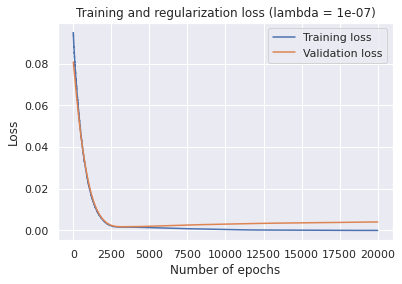

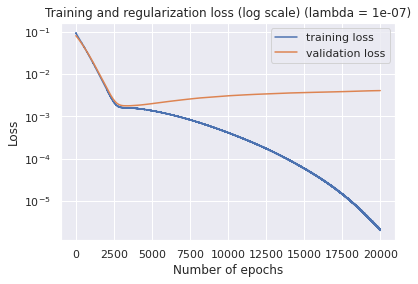

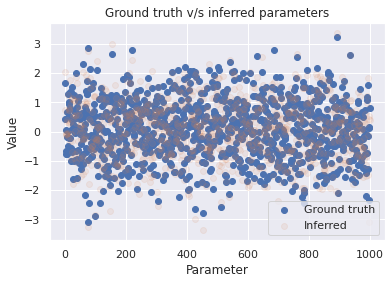

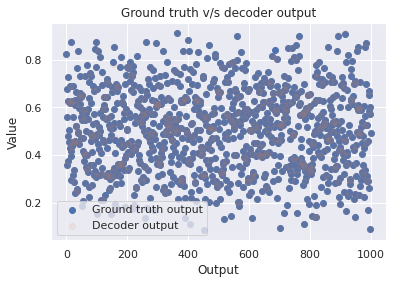

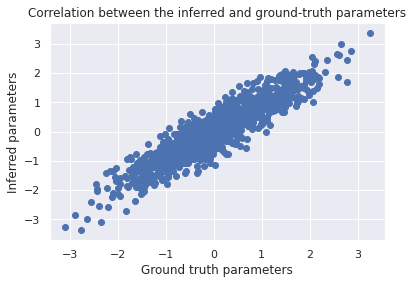

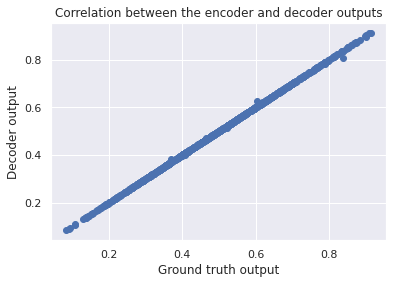

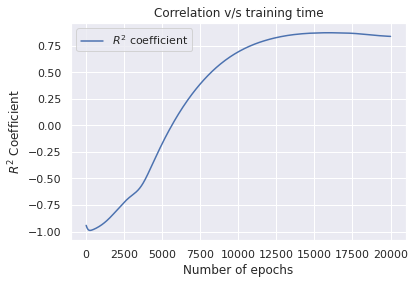

In [94]:
# Coefficient for the penalty = 100

model_decoder_var_penality_100 = neuron_unit_decoder_w_hidden_init_fix().to(device)
model_training_params = train_decoder_w_hidden_w_var_penalty(
    model_decoder_var_penality_100,
    loss_fn,
    l_norm=5,
    var_coeff=1,
    n_epochs=20000,
    n_lambda=10e-8,
)
evaluate_model(
    model=model_decoder_var_penality_100,
    datagen=datagen,
    model_training_params=model_training_params,
    l2_lambda=10e-8,
    reg_flag=False,
)